In [2]:
from itertools import product
import numpy as np
import pandas as pd
from ADRprofilePrediction import Pairs2Mat, evaluation, evaluation2
from APPFC import completion
from Models import loadHyperpar
import seaborn as sns 
import matplotlib.pylab as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patheffects as path_effects
import json
import pingouin as pg
from functools import reduce

In [3]:

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

In [4]:
import sklearn
print(sklearn.__version__)

0.24.2


In [5]:
SEs_name = "SIDER"
metrice = "mse"

In [6]:
features_dict = {
    "target":Pairs2Mat(path="data/drug_target.tsv",colname1="0",colname2="1"),
    "enzyme":Pairs2Mat(path="data/drug_enzyme.tsv",colname1="0",colname2="1"),
    "Chem":pd.read_csv("data/drug_chemsfp.tsv",sep = "\t",header=0,index_col=0),
    "DGI":Pairs2Mat(path="data/interactions.tsv",colname1="drug_claim_name",colname2="gene_name"),
    "transporter":Pairs2Mat(path="data/drug_transporter.tsv",colname1="0",colname2="1"),
    "pathway":Pairs2Mat(path="data/drug_pathway.tsv",colname1="0",colname2="1"),
    "indication":Pairs2Mat(path="data/drug_indication.tsv",colname1="1_x",colname2="6")
}


In [7]:
filter = "all"
SEs = {}
if filter == "all":
    SIDER = Pairs2Mat(path="data/drug_se.tsv",colname1="1_x",colname2="5")
    column_sums = np.sum(SIDER, axis=0)
    SEs["SIDER"] = SIDER.loc[:, (column_sums >= 5)]

    OFFSIDES = Pairs2Mat(path="data/OFFSIDES.csv",colname1="drug_concept_name",colname2="condition_concept_name",sep = ",")
    column_sums = np.sum(OFFSIDES, axis=0)
    SEs["OFFSIDES"] = OFFSIDES.loc[:, column_sums >= 5]
elif filter == "rare":
    SIDER = Pairs2Mat(path="data/drug_se.tsv",colname1="1_x",colname2="5")
    column_sums = np.sum(SIDER, axis=0)
    SEs["SIDER"] = SIDER.loc[:, (column_sums < 50)]

    OFFSIDES = Pairs2Mat(path="data/OFFSIDES.csv",colname1="drug_concept_name",colname2="condition_concept_name",sep = ",")
    column_sums = np.sum(OFFSIDES, axis=0)
    SEs["OFFSIDES"] = OFFSIDES.loc[:, column_sums < 50]


In [8]:
SEs["SIDER"].shape

(1344, 2556)

In [9]:
SEs["OFFSIDES"].shape

(2730, 12750)

In [10]:

df_dict = features_dict
intersection_indices = df_dict['target'].index
for df_name, df in df_dict.items():
    intersection_indices = intersection_indices.intersection(df.index)
intersection_indices = intersection_indices.tolist()
print("Intersection indices:", intersection_indices)
print("Size of intersection set", len(intersection_indices))

Intersection indices: ['ACETAMINOPHEN', 'ACETAZOLAMIDE', 'ALFENTANIL', 'ALLOPURINOL', 'AMANTADINE', 'AMIODARONE', 'AMITRIPTYLINE', 'AMLODIPINE', 'AMOXICILLIN', 'AMPRENAVIR', 'ANASTROZOLE', 'APIXABAN', 'APOMORPHINE', 'ARIPIPRAZOLE', 'ATAZANAVIR', 'ATENOLOL', 'AZATHIOPRINE', 'AZELASTINE', 'AZITHROMYCIN', 'BENAZEPRIL', 'BENZOCAINE', 'BEPRIDIL', 'BETAMETHASONE', 'BEZAFIBRATE', 'BICALUTAMIDE', 'BISOPROLOL', 'BOSENTAN', 'BOSUTINIB', 'BROMOCRIPTINE', 'BUMETANIDE', 'BUPRENORPHINE', 'BUSPIRONE', 'CABERGOLINE', 'CANAGLIFLOZIN', 'CANDESARTAN', 'CARBAMAZEPINE', 'CARBOPLATIN', 'CARVEDILOL', 'CEFACLOR', 'CEFAZOLIN', 'CEFTRIAXONE', 'CELECOXIB', 'CERIVASTATIN', 'CHLORAMBUCIL', 'CHLORPROMAZINE', 'CHLORPROPAMIDE', 'CIDOFOVIR', 'CIMETIDINE', 'CINOXACIN', 'CIPROFLOXACIN', 'CISPLATIN', 'CITALOPRAM', 'CLADRIBINE', 'CLARITHROMYCIN', 'CLOBAZAM', 'CLOMIPRAMINE', 'CLONIDINE', 'CLOPIDOGREL', 'CLOTRIMAZOLE', 'CODEINE', 'COLCHICINE', 'CRIZOTINIB', 'CYPROHEPTADINE', 'DAPAGLIFLOZIN', 'DARUNAVIR', 'DASATINIB', 'DESIP

In [11]:
features_names = ["target", "enzyme", "Chem", "DGI", "transporter", "pathway", "indication"]
# SEs_names = ["SIDER", "OFFSIDES"]
# methods = ["SKR", "KR", "KRR", "Naive", "LNSM_RLN", "LNSM_jaccard", "VKR"]
methods = ["SKR", "KRR", "VKR", "Naive", "LNSM_RLN", "LNSM_jaccard"]
# methods = ["SKR", "KR", "KRR", "Naive", "LNSM_RLN", "LNSM_jaccard", "VKR", "SVM", "OCCA", "SCCA", "RF", "BRF"]
tuning_metrices=["AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]
metrice_names = ["AUPR+AUROC", "AUPR+AUROCperdrug", "AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]

In [12]:
A = 10**np.arange(-2, 3, 1, dtype=float)
B = np.arange(0.1, 1, 0.1, dtype=float)
C = np.arange(5, 205, 50, dtype=int)
C2 = np.arange(5, 20, 5, dtype=int)
A10 = 10**np.arange(1, 2, 1, dtype=float)
A100 = 10**np.arange(2, 3, 1, dtype=float)
all_hyperparlist = {
    "SKR":[A,B,A10,A100], 
    # "KR":[A,A], 
    "KRR":[A,A],
    "VKR":[A,A,C2], 
    # "Naive":[], 
    # "LNSM_RLN":[B,A], 
    # "LNSM_jaccard":[B], 
    # "SVM":[A,A,A], 
    # "OCCA":[], 
    # "SCCA":[A], 
    # "RF":[C], 
    # "BRF":[C],
    "TNMF":[C],
    "TWNMF":[C]
}

In [11]:
fhyperpars = {}
fhyperpars["nested_cv"] = {}
fhyperpars["cv"] = {}
fhyperparsOut = {}
fhyperparsOut["nested_cv"] = {}
fhyperparsOut["cv"] = {}
fresults = {}
fresults["nested_cv"] = {}
fresults["cv"] = {}

In [12]:

# Open and read the JSON file
# with open(f'results/hyperpars_{SEs_name}.xml', 'r') as xml_file:

#     hyperpars = json.load(xml_file)

In [13]:
method = "TNMF"
validation = "nested_cv"
fhyperparsOut[validation][method] = {}
fresults[validation][method] = {}
hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
fresults[validation][method], fhyperparsOut[validation][method], features_new = completion(Y=SEs[SEs_name], X=features_dict, method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=3)

validation = "cv"
fhyperparsOut[validation][method] = {}
fresults[validation][method] = {}
hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
fresults[validation], fhyperparsOut[validation][method], features_new = completion(Y=SEs[SEs_name], X=features_dict, method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=1)

The TNMF requires hyperparameter k


common drugs chosen to be the test set:  set()
---------- nested cv start ----------
Fold: 0
number of hyperpars combination:  4
Inner Fold: 0
Inner Fold: 1
Inner Fold: 2
Inner Fold: 3
best hyperpar: (105,)
mse: -0.006076977041917136
mse for each fold: [-0.00636868 -0.00622129 -0.00613204 -0.00558589]
--- tuning end ---
target size: 7
------ best hyper pars:  (105,) ------
TNMF starts:
TNMF ends:
-----------
mse: 0.005803422484144769
AUPR: 0.14062690400250116
AUROC: 0.839308248551252
-----------
Fold: 1
number of hyperpars combination:  4
Inner Fold: 0
Inner Fold: 1
Inner Fold: 2
Inner Fold: 3
best hyperpar: (105,)
mse: -0.0060309650439749184
mse for each fold: [-0.0064488  -0.00615584 -0.00593183 -0.0055874 ]
--- tuning end ---
target size: 7
------ best hyper pars:  (105,) ------
TNMF starts:
TNMF ends:
-----------
mse: 0.0058236133825377385
AUPR: 0.16222386342917217
AUROC: 0.8302940550541011
-----------
Fold: 2
number of hyperpars combination:  4
Inner Fold: 0
Inner Fold: 1
Inner Fo

In [19]:
fhyperparsOut

{'nested_cv': {'TNMF': [(105,), (105,), (105,), (105,), (105,)]},
 'cv': {'TNMF': (105,)}}

In [43]:
with open(f'results/fhyperpars_{SEs_name}.xml', 'w') as xml_file:
   json.dump(fhyperparsOut, xml_file, cls=NpEncoder)
with open(f'results/fresults_{SEs_name}_{method}.xml', 'w') as xml_file:
   json.dump(fresults, xml_file)

In [ ]:
# method = "KRR"
# validation = "nested_cv"
# hyperparsOut[validation][method] = {}
# results[validation][method] = {}
# str = "DGI"
# hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
# results[validation][method]["noAPPFC"][str], hyperparsOut[validation][method][str]["noAPPFC"] = evaluation(Y=SEs["SIDER"], X=features_dict[str], method_option=method,tuning_metrice=metrice, hyperparList=hyperparList,Validation=validation,n_jobs=1)

In [23]:
method = "TNMF"
validation = "completion"
hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
features_new = completion(Y=SEs[SEs_name], X=features_dict,method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,hyperparfixed=(105,),Validation=validation,n_jobs=1)

The TNMF requires hyperparameter k
common drugs chosen to be the test set:  set()
TNMF starts:
TNMF ends:


In [24]:
hyperpars = {}
hyperpars["nested_cv"] = {}
hyperpars["cv"] = {}
hyperparsOut = {}
hyperparsOut["nested_cv"] = {}
hyperparsOut["cv"] = {}
results = {}
results["nested_cv"] = {}
results["cv"] = {}

In [25]:
method = "KRR"
metrice = "AUPR"
validation = "nested_cv"
hyperparsOut[validation][method] = {}
results[validation][method] = {}
hyperparsOut[validation][method]["noAPPFC"] = {}
results[validation][method]["noAPPFC"] = {}
hyperparsOut[validation][method]["APPFC"] = {}
results[validation][method]["APPFC"] = {}
for str in features_names:
    print(f"using feature {str}")
    print("without APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["noAPPFC"][str], hyperparsOut[validation][method]["noAPPFC"][str] = evaluation(Y=SEs[SEs_name], X=features_dict[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=1)
    print("with APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["APPFC"][str], hyperparsOut[validation][method]["APPFC"][str] = evaluation2(Y=SEs[SEs_name], X=features_dict[str], X2=features_new[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=10)

using feature target
without APPFC
The KRR requires hyperparameter lambda, sigma_X


---------- nested cv start ----------
Fold: 0
number of hyperpars combination:  25
first few training idx:  [20 22 23 25 28 29 31 36 39 40]
first few testing idx:  [ 153  283  397  440  800  857  858 1177 1230 1327]
Inner Fold: 0
Inner Fold: 1
Inner Fold: 2
Inner Fold: 3
best hyperpar: (0.1, 10.0)
AUPR: 0.4064772166941648
AUPR for each fold: [0.42919152 0.40186879 0.39300813 0.40184043]
--- tuning end ---
target size: 142
------ best hyper pars:  (0.1, 10.0) ------
KRR starts:
KRR ends:
-----------
AUPRperdrug: 0.459685081730273
AUROCperdrug: 0.8979308325741943
AUPR+AUROCperdrug: 1.3576159143044673
AUPR: 0.4059389936109691
AUROC: 0.8684318674310184
AUPR+AUROC: 1.2743708610419875
-----------
Fold: 1
number of hyperpars combination:  25
first few training idx:  [22 23 25 28 29 31 40 41 44 45]
first few testing idx:  [ 125  164  480  518  552  696  913  919 1277 1310]
Inner Fold: 0
Inner Fold: 1
Inner Fold: 2
Inner Fold: 3
best hyperpar: (0.1, 10.0)
AUPR: 0.40023685060432834
AUPR for each

In [26]:
method = "KRR"
validation = "cv"
hyperparsOut[validation][method] = {}
results[validation][method] = {}
hyperparsOut[validation][method]["noAPPFC"] = {}
results[validation][method]["noAPPFC"] = {}
hyperparsOut[validation][method]["APPFC"] = {}
results[validation][method]["APPFC"] = {}
for str in features_names:
    print(f"using feature {str}")
    print("without APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["noAPPFC"][str], hyperparsOut[validation][method]["noAPPFC"][str] = evaluation(Y=SEs[SEs_name], X=features_dict[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=1)
    print("with APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["APPFC"][str], hyperparsOut[validation][method]["APPFC"][str] = evaluation2(Y=SEs[SEs_name], X=features_dict[str], X2=features_new[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=10)

using feature target
without APPFC
The KRR requires hyperparameter lambda, sigma_X
---------- cv start ----------
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
best hyperpar: (0.1, 10.0)
AUPR: 0.4103775351759735
AUPR for each fold: [0.40593899 0.40283674 0.39940035 0.44389761 0.39981398]
--- tuning end ---
target size: 227
------ best hyper pars:  (0.1, 10.0) ------
KRR starts:
KRR ends:
-----------
AUPRperdrug: 0.4738755021740858
AUROCperdrug: 0.8995013792933797
AUPR+AUROCperdrug: 1.3733768814674656
AUPR: 0.4201811402179553
AUROC: 0.8711552922545547
AUPR+AUROC: 1.29133643247251
-----------
with APPFC
The KRR requires hyperparameter lambda, sigma_X
---------- cv start ----------
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
best hyperpar: (0.01, 10.0)
AUPR: 0.45285279943664125
AUPR for each fold: [0.44378721 0.43593632 0.44302261 0.47769863 0.46381922]
--- tuning end ---
target size: 227
------ best hyper pars:  (0.01, 10.0) ------
KRR starts:
KRR ends:
-----------
AUPRperdrug: 0.48866612399761344

In [99]:
method = "KRR"
df = pd.DataFrame()
for m, fs in results["nested_cv"]["KRR"].items():
    for f, mes in fs.items():
        for me, scores in mes.items():
            temp_df = pd.DataFrame({
                'method': m,
                'feature': f,
                'metric': me,
                "score": scores
            })
            df = pd.concat([df, temp_df], ignore_index=True)

custom_order = ["pathway","Chem", "DGI", "indication", "target", "transporter", "enzyme"]
# metrice_names = ["AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]
metrice_names = ["AUPR+AUROC", "AUPR+AUROCperdrug", "AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]
APPFC = ["APPFC", "noAPPFC"]
df['feature'] = pd.Categorical(df['feature'], categories=custom_order, ordered=True)
df['method'] = pd.Categorical(df['method'], categories=APPFC, ordered=True)
df['metric'] = pd.Categorical(df['metric'], categories=metrice_names, ordered=True)
df2 = pd.pivot_table(df, values=['score'], index=["feature", "method"], aggfunc={'score': ["mean","std"]}, columns=["metric"])
df3 = df2.sort_index(axis=1, level='metric').sort_index(level='feature')
df3.to_excel(f'results/nested_cv_results_{SEs_name}_{method}.xlsx')
df3

score                                                 \
                          mean        std              mean               std   
metric              AUPR+AUROC AUPR+AUROC AUPR+AUROCperdrug AUPR+AUROCperdrug   
feature     method                                                              
pathway     APPFC     1.351755   0.014678          1.400619          0.009003   
            noAPPFC   1.314502   0.026516          1.392919          0.015386   
Chem        APPFC     1.267763   0.033335          1.343103          0.017732   
            noAPPFC   1.259418   0.030815          1.344612          0.021969   
DGI         APPFC     1.322624   0.030985          1.373009          0.011342   
            noAPPFC   1.282242   0.020611          1.345147          0.006961   
indication  APPFC     1.327516   0.015695          1.356466          0.014540   
            noAPPFC   1.334615   0.012151          1.360746          0.006217   
target      APPFC     1.328753   0.018917          1.382269          0.020408   
            noAPPFC   1.282878   0.021430          1.362296          0.020969   
transporter APPFC     1.321447   0.042509          1.386798          0.040551   
            noAPPFC   1.290083   0.046447          1.366099          0.041043   
enzyme      APPFC     1.286094   0.038070          1.343169          0.016528   
            noAPPFC   1.258437   0.031868          1.324738          0.015227   

                                                                          \
                         mean       std      mean       std         mean   
metric                  AUROC     AUROC      AUPR      AUPR AUROCperdrug   
feature     method                                                         
pathway     APPFC    0.882162  0.002369  0.469592  0.013368     0.905010   
            noAPPFC  0.863253  0.007199  0.451248  0.019692     0.892696   
Chem        APPFC    0.845471  0.008708  0.422292  0.025857     0.877979   
            noAPPFC  0.854482  0.010330  0.404936  0.022589     0.884176   
DGI         APPFC    0.877172  0.012822  0.445451  0.023759     0.901914   
            noAPPFC  0.859625  0.010605  0.422617  0.013225     0.887342   
indication  APPFC    0.879855  0.006655  0.447661  0.011923     0.900635   
            noAPPFC  0.874529  0.004588  0.460086  0.008115     0.894389   
target      APPFC    0.875901  0.005109  0.452853  0.017339     0.901639   
            noAPPFC  0.872500  0.003333  0.410378  0.018923     0.899511   
transporter APPFC    0.869373  0.011849  0.452074  0.033026     0.894490   
            noAPPFC  0.864865  0.011109  0.425218  0.036553     0.888563   
enzyme      APPFC    0.865520  0.011716  0.420574  0.026678     0.889772   
            noAPPFC  0.863750  0.009264  0.394687  0.024632     0.883361   

                                                          
                             std        mean         std  
metric              AUROCperdrug AUPRperdrug AUPRperdrug  
feature     method                                        
pathway     APPFC       0.002528    0.495609    0.006661  
            noAPPFC     0.004520    0.500223    0.010999  
Chem        APPFC       0.003840    0.465124    0.017809  
            noAPPFC     0.003746    0.460436    0.019664  
DGI         APPFC       0.004499    0.471095    0.007708  
            noAPPFC     0.004044    0.457805    0.003769  
indication  APPFC       0.004164    0.455832    0.011431  
            noAPPFC     0.002536    0.466357    0.006216  
target      APPFC       0.002335    0.480630    0.019245  
            noAPPFC     0.004010    0.462785    0.018485  
transporter APPFC       0.006252    0.492308    0.035358  
            noAPPFC     0.006475    0.477536    0.035068  
enzyme      APPFC       0.001565    0.453397    0.015313  
            noAPPFC     0.002319    0.441378    0.013411

In [100]:
df = pd.DataFrame()
for m, fs in results["cv"]["KRR"].items():
    for f, mes in fs.items():
        for me, scores in mes.items():
            temp_df = pd.DataFrame({
                'method': m,
                'feature': f,
                'metric': me,
                "score": scores
            },index=["1"])
            df = pd.concat([df, temp_df], ignore_index=True)
df['feature'] = pd.Categorical(df['feature'], categories=custom_order, ordered=True)
df['method'] = pd.Categorical(df['method'], categories=APPFC, ordered=True)
df['metric'] = pd.Categorical(df['metric'], categories=metrice_names, ordered=True)
df2 = pd.pivot_table(df, values=['score'], index=["feature", "method"], columns="metric")
df2.to_excel(f'results/cv_results_{SEs_name}_{method}.xlsx')
df2

score                                        \
metric              AUPR+AUROC AUPR+AUROCperdrug     AUROC      AUPR   
feature     method                                                     
pathway     APPFC     1.361434          1.421141  0.877731  0.483703   
            noAPPFC   1.324840          1.410253  0.866914  0.457926   
Chem        APPFC     1.319596          1.342639  0.849940  0.469656   
            noAPPFC   1.273473          1.355337  0.852868  0.420605   
DGI         APPFC     1.371162          1.401224  0.888497  0.482665   
            noAPPFC   1.311724          1.364207  0.862463  0.449261   
indication  APPFC     1.345087          1.372842  0.876939  0.468148   
            noAPPFC   1.356748          1.379264  0.875209  0.481539   
target      APPFC     1.340815          1.388632  0.877562  0.463252   
            noAPPFC   1.291336          1.373377  0.871155  0.420181   
transporter APPFC     1.343943          1.417692  0.871792  0.472150   
            noAPPFC   1.328855          1.400351  0.868129  0.460726   
enzyme      APPFC     1.338632          1.381410  0.869615  0.469017   
            noAPPFC   1.288209          1.357770  0.859114  0.429096   

                                              
metric              AUROCperdrug AUPRperdrug  
feature     method                            
pathway     APPFC       0.905097    0.516044  
            noAPPFC     0.895607    0.514646  
Chem        APPFC       0.869656    0.472983  
            noAPPFC     0.883977    0.471360  
DGI         APPFC       0.908106    0.493118  
            noAPPFC     0.889383    0.474824  
indication  APPFC       0.902353    0.470489  
            noAPPFC     0.896333    0.482931  
target      APPFC       0.899966    0.488666  
            noAPPFC     0.899501    0.473876  
transporter APPFC       0.894053    0.523639  
            noAPPFC     0.887525    0.512826  
enzyme      APPFC       0.889554    0.491856  
            noAPPFC     0.881059    0.476711

In [29]:
method = "SKR"
metrice = "AUPR"
validation = "nested_cv"
hyperparsOut[validation][method] = {}
results[validation][method] = {}
hyperparsOut[validation][method]["noAPPFC"] = {}
results[validation][method]["noAPPFC"] = {}
hyperparsOut[validation][method]["APPFC"] = {}
results[validation][method]["APPFC"] = {}
for str in features_names:
    print(f"using feature {str}")
    print("without APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["noAPPFC"][str], hyperparsOut[validation][method]["noAPPFC"][str] = evaluation(Y=SEs[SEs_name], X=features_dict[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=1)
    print("with APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["APPFC"][str], hyperparsOut[validation][method]["APPFC"][str] = evaluation2(Y=SEs[SEs_name], X=features_dict[str], X2=features_new[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=10)

using feature target
without APPFC
The SKR requires hyperparameter lambda, c, sigma_X, sigma_Y
---------- nested cv start ----------
Fold: 0
number of hyperpars combination:  45
first few training idx:  [20 22 23 25 28 29 31 36 39 40]
first few testing idx:  [ 153  283  397  440  800  857  858 1177 1230 1327]
Inner Fold: 0
Inner Fold: 1
Inner Fold: 2
Inner Fold: 3
best hyperpar: (0.01, 0.4, 10.0, 100.0)
AUPR: 0.4106493707056941
AUPR for each fold: [0.43377044 0.40668726 0.40595658 0.3961832 ]
--- tuning end ---
target size: 142
------ best hyper pars:  (0.01, 0.4, 10.0, 100.0) ------
SKR starts:
SKR ends:
-----------
AUPRperdrug: 0.46165763532831294
AUROCperdrug: 0.8978972570529985
AUPR+AUROCperdrug: 1.3595548923813114
AUPR: 0.41537111662266546
AUROC: 0.8687649873476412
AUPR+AUROC: 1.2841361039703068
-----------
Fold: 1
number of hyperpars combination:  45
first few training idx:  [22 23 25 28 29 31 40 41 44 45]
first few testing idx:  [ 125  164  480  518  552  696  913  919 1277 1310

In [30]:
method = "SKR"
validation = "cv"
hyperparsOut[validation][method] = {}
results[validation][method] = {}
hyperparsOut[validation][method]["noAPPFC"] = {}
results[validation][method]["noAPPFC"] = {}
hyperparsOut[validation][method]["APPFC"] = {}
results[validation][method]["APPFC"] = {}
for str in features_names:
    print(f"using feature {str}")
    print("without APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["noAPPFC"][str], hyperparsOut[validation][method]["noAPPFC"][str] = evaluation(Y=SEs[SEs_name], X=features_dict[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=1)
    print("with APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["APPFC"][str], hyperparsOut[validation][method]["APPFC"][str] = evaluation2(Y=SEs[SEs_name], X=features_dict[str], X2=features_new[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=10)

using feature target
without APPFC
The SKR requires hyperparameter lambda, c, sigma_X, sigma_Y
---------- cv start ----------
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
best hyperpar: (0.01, 0.4, 10.0, 100.0)
AUPR: 0.41605384442571314
AUPR for each fold: [0.41537112 0.40631156 0.40573483 0.44647569 0.40637602]
--- tuning end ---
target size: 227
------ best hyper pars:  (0.01, 0.4, 10.0, 100.0) ------
SKR starts:
SKR ends:
-----------
AUPRperdrug: 0.47917785005778074
AUROCperdrug: 0.8982555123315037
AUPR+AUROCperdrug: 1.3774333623892845
AUPR: 0.4284397347687574
AUROC: 0.8700496684958257
AUPR+AUROC: 1.298489403264583
-----------
with APPFC
The SKR requires hyperparameter lambda, c, sigma_X, sigma_Y
---------- cv start ----------
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
best hyperpar: (0.01, 0.1, 10.0, 100.0)
AUPR: 0.4541776529731371
AUPR for each fold: [0.44565191 0.43693031 0.44488512 0.47931683 0.4641041 ]
--- tuning end ---
target size: 227
------ best hyper pars:  (0.01, 0.1, 10.0, 100.

In [101]:
method = "SKR"
df = pd.DataFrame()
for m, fs in results["nested_cv"]["SKR"].items():
    for f, mes in fs.items():
        for me, scores in mes.items():
            temp_df = pd.DataFrame({
                'method': m,
                'feature': f,
                'metric': me,
                "score": scores
            })
            df = pd.concat([df, temp_df], ignore_index=True)

custom_order = ["pathway","Chem", "DGI",  "indication", "target", "transporter", "enzyme"]
# metrice_names = ["AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]
metrice_names = ["AUPR+AUROC", "AUPR+AUROCperdrug", "AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]
APPFC = ["APPFC", "noAPPFC"]
df['feature'] = pd.Categorical(df['feature'], categories=custom_order, ordered=True)
df['method'] = pd.Categorical(df['method'], categories=APPFC, ordered=True)
df['metric'] = pd.Categorical(df['metric'], categories=metrice_names, ordered=True)
df2 = pd.pivot_table(df, values=['score'], index=["feature", "method"], aggfunc={'score': ["mean","std"]}, columns=["metric"])
df3 = df2.sort_index(axis=1, level='metric').sort_index(level='feature')
df3.to_excel(f'results/nested_cv_results_{SEs_name}_{method}.xlsx')
df3

score                                                 \
                          mean        std              mean               std   
metric              AUPR+AUROC AUPR+AUROC AUPR+AUROCperdrug AUPR+AUROCperdrug   
feature     method                                                              
pathway     APPFC     1.354047   0.014720          1.400310          0.009097   
            noAPPFC   1.334704   0.025306          1.404288          0.013062   
Chem        APPFC     1.315813   0.026486          1.374147          0.020111   
            noAPPFC   1.274720   0.031367          1.356032          0.024330   
DGI         APPFC     1.330584   0.026704          1.374545          0.011539   
            noAPPFC   1.292961   0.020200          1.352780          0.006536   
indication  APPFC     1.331600   0.017163          1.358293          0.012417   
            noAPPFC   1.339038   0.012389          1.364707          0.006074   
target      APPFC     1.335483   0.018594          1.384377          0.020781   
            noAPPFC   1.286860   0.016519          1.363995          0.020215   
transporter APPFC     1.327378   0.043784          1.388783          0.041441   
            noAPPFC   1.288785   0.045906          1.364281          0.040914   
enzyme      APPFC     1.290627   0.035665          1.346609          0.016490   
            noAPPFC   1.261235   0.029193          1.327933          0.016083   

                                                                          \
                         mean       std      mean       std         mean   
metric                  AUROC     AUROC      AUPR      AUPR AUROCperdrug   
feature     method                                                         
pathway     APPFC    0.884172  0.002452  0.469875  0.013572     0.906168   
            noAPPFC  0.877330  0.007133  0.457374  0.018828     0.902620   
Chem        APPFC    0.868088  0.005266  0.447725  0.025662     0.896316   
            noAPPFC  0.866258  0.009745  0.408462  0.022857     0.893329   
DGI         APPFC    0.876175  0.013462  0.454409  0.016374     0.902496   
            noAPPFC  0.867722  0.009917  0.425239  0.012524     0.893452   
indication  APPFC    0.881731  0.008399  0.449869  0.012357     0.902401   
            noAPPFC  0.878411  0.004570  0.460628  0.008515     0.897980   
target      APPFC    0.881346  0.004185  0.454137  0.017096     0.905280   
            noAPPFC  0.871114  0.001762  0.415746  0.016734     0.899459   
transporter APPFC    0.873052  0.010931  0.454326  0.035045     0.896809   
            noAPPFC  0.864136  0.010183  0.424649  0.037006     0.888165   
enzyme      APPFC    0.869577  0.011073  0.421050  0.025147     0.892260   
            noAPPFC  0.865739  0.008615  0.395497  0.022735     0.885247   

                                                          
                             std        mean         std  
metric              AUROCperdrug AUPRperdrug AUPRperdrug  
feature     method                                        
pathway     APPFC       0.002169    0.494142    0.007173  
            noAPPFC     0.003697    0.501668    0.009512  
Chem        APPFC       0.003016    0.477830    0.021164  
            noAPPFC     0.004395    0.462704    0.020576  
DGI         APPFC       0.004713    0.472050    0.007498  
            noAPPFC     0.003387    0.459328    0.003854  
indication  APPFC       0.003539    0.455892    0.011061  
            noAPPFC     0.002567    0.466726    0.006338  
target      APPFC       0.002803    0.479097    0.019526  
            noAPPFC     0.004993    0.464536    0.017300  
transporter APPFC       0.006011    0.491973    0.036137  
            noAPPFC     0.006043    0.476116    0.035336  
enzyme      APPFC       0.001996    0.454349    0.014850  
            noAPPFC     0.002137    0.442687    0.014267

In [102]:
method = "SKR"
df = pd.DataFrame()
for m, fs in results["cv"]["SKR"].items():
    for f, mes in fs.items():
        for me, scores in mes.items():
            temp_df = pd.DataFrame({
                'method': m,
                'feature': f,
                'metric': me,
                "score": scores
            },index=["1"])
            df = pd.concat([df, temp_df], ignore_index=True)
df['feature'] = pd.Categorical(df['feature'], categories=custom_order, ordered=True)
df['method'] = pd.Categorical(df['method'], categories=APPFC, ordered=True)
df['metric'] = pd.Categorical(df['metric'], categories=metrice_names, ordered=True)
df2 = pd.pivot_table(df, values=['score'], index=["feature", "method"], columns="metric")
df2.to_excel(f'results/cv_results_{SEs_name}_{method}.xlsx')
df2

score                                        \
metric              AUPR+AUROC AUPR+AUROCperdrug     AUROC      AUPR   
feature     method                                                     
pathway     APPFC     1.365092          1.421943  0.880298  0.484794   
            noAPPFC   1.345507          1.423435  0.878959  0.466547   
Chem        APPFC     1.360565          1.393283  0.879089  0.481476   
            noAPPFC   1.288654          1.370659  0.865865  0.422789   
DGI         APPFC     1.378348          1.402222  0.887114  0.491234   
            noAPPFC   1.320788          1.374990  0.871058  0.449730   
indication  APPFC     1.344627          1.372072  0.877720  0.466906   
            noAPPFC   1.361208          1.383549  0.879210  0.481998   
target      APPFC     1.344655          1.391887  0.879897  0.464758   
            noAPPFC   1.298489          1.377433  0.870050  0.428440   
transporter APPFC     1.352553          1.420758  0.874956  0.477597   
            noAPPFC   1.329255          1.401328  0.868501  0.460753   
enzyme      APPFC     1.340055          1.384532  0.872420  0.467635   
            noAPPFC   1.292667          1.361520  0.861777  0.430890   

                                              
metric              AUROCperdrug AUPRperdrug  
feature     method                            
pathway     APPFC       0.906625    0.515318  
            noAPPFC     0.904862    0.518574  
Chem        APPFC       0.899578    0.493705  
            noAPPFC     0.894982    0.475677  
DGI         APPFC       0.908111    0.494112  
            noAPPFC     0.896389    0.478601  
indication  APPFC       0.902434    0.469638  
            noAPPFC     0.899894    0.483655  
target      APPFC       0.901897    0.489990  
            noAPPFC     0.898256    0.479178  
transporter APPFC       0.896207    0.524552  
            noAPPFC     0.888093    0.513235  
enzyme      APPFC       0.891539    0.492993  
            noAPPFC     0.882983    0.478537

In [33]:
method = "VKR"
metrice = "AUPR"
validation = "nested_cv"
hyperparsOut[validation][method] = {}
results[validation][method] = {}
hyperparsOut[validation][method]["noAPPFC"] = {}
results[validation][method]["noAPPFC"] = {}
hyperparsOut[validation][method]["APPFC"] = {}
results[validation][method]["APPFC"] = {}
for str in features_names:
    print(f"using feature {str}")
    print("without APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["noAPPFC"][str], hyperparsOut[validation][method]["noAPPFC"][str] = evaluation(Y=SEs[SEs_name], X=features_dict[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=1)
    print("with APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["APPFC"][str], hyperparsOut[validation][method]["APPFC"][str] = evaluation2(Y=SEs[SEs_name], X=features_dict[str], X2=features_new[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=10)

using feature target
without APPFC
The VKR requires hyperparameter lambda, sigma_X, k
---------- nested cv start ----------
Fold: 0
number of hyperpars combination:  75
first few training idx:  [20 22 23 25 28 29 31 36 39 40]
first few testing idx:  [ 153  283  397  440  800  857  858 1177 1230 1327]
Inner Fold: 0
Inner Fold: 1
Inner Fold: 2
Inner Fold: 3
best hyperpar: (10.0, 0.1, 15)
AUPR: 0.3992770248586124
AUPR for each fold: [0.41734197 0.39677105 0.38819991 0.39479517]
--- tuning end ---
target size: 142
------ best hyper pars:  (10.0, 0.1, 15) ------
VKR starts:
VKR ends:
-----------
AUPRperdrug: 0.4430073624659947
AUROCperdrug: 0.8940083485266516
AUPR+AUROCperdrug: 1.3370157109926462
AUPR: 0.3952735561209576
AUROC: 0.8713008316129538
AUPR+AUROC: 1.2665743877339115
-----------
Fold: 1
number of hyperpars combination:  75
first few training idx:  [22 23 25 28 29 31 40 41 44 45]
first few testing idx:  [ 125  164  480  518  552  696  913  919 1277 1310]
Inner Fold: 0
Inner Fold: 1

In [34]:
method = "VKR"
validation = "cv"
hyperparsOut[validation][method] = {}
results[validation][method] = {}
hyperparsOut[validation][method]["noAPPFC"] = {}
results[validation][method]["noAPPFC"] = {}
hyperparsOut[validation][method]["APPFC"] = {}
results[validation][method]["APPFC"] = {}
for str in features_names:
    print(f"using feature {str}")
    print("without APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["noAPPFC"][str], hyperparsOut[validation][method]["noAPPFC"][str] = evaluation(Y=SEs[SEs_name], X=features_dict[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=1)
    print("with APPFC")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[validation][method]["APPFC"][str], hyperparsOut[validation][method]["APPFC"][str] = evaluation2(Y=SEs[SEs_name], X=features_dict[str], X2=features_new[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,Validation=validation,n_jobs=10)

using feature target
without APPFC
The VKR requires hyperparameter lambda, sigma_X, k
---------- cv start ----------
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
best hyperpar: (10.0, 0.01, 15)
AUPR: 0.4008312456562574
AUPR for each fold: [0.40626683 0.38737833 0.39522863 0.4275341  0.38774834]
--- tuning end ---
target size: 227
------ best hyper pars:  (10.0, 0.01, 15) ------
VKR starts:
VKR ends:
-----------
AUPRperdrug: 0.4691483542650316
AUROCperdrug: 0.8971566359670718
AUPR+AUROCperdrug: 1.3663049902321034
AUPR: 0.4206970837822405
AUROC: 0.8750439928782914
AUPR+AUROC: 1.295741076660532
-----------
with APPFC
The VKR requires hyperparameter lambda, sigma_X, k
---------- cv start ----------
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
best hyperpar: (10.0, 0.01, 15)
AUPR: 0.4399813882457237
AUPR for each fold: [0.43350137 0.42328562 0.43612028 0.45953494 0.44746473]
--- tuning end ---
target size: 227
------ best hyper pars:  (10.0, 0.01, 15) ------
VKR starts:
VKR ends:
-----------
AUPRperd

In [103]:
method = "VKR"
df = pd.DataFrame()
for m, fs in results["nested_cv"]["VKR"].items():
    for f, mes in fs.items():
        for me, scores in mes.items():
            temp_df = pd.DataFrame({
                'method': m,
                'feature': f,
                'metric': me,
                "score": scores
            })
            df = pd.concat([df, temp_df], ignore_index=True)

custom_order = ["pathway","Chem", "DGI",  "indication", "target", "transporter", "enzyme"]
# metrice_names = ["AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]
metrice_names = ["AUPR+AUROC", "AUPR+AUROCperdrug", "AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]
APPFC = ["APPFC", "noAPPFC"]
df['feature'] = pd.Categorical(df['feature'], categories=custom_order, ordered=True)
df['method'] = pd.Categorical(df['method'], categories=APPFC, ordered=True)
df['metric'] = pd.Categorical(df['metric'], categories=metrice_names, ordered=True)
df2 = pd.pivot_table(df, values=['score'], index=["feature", "method"], aggfunc={'score': ["mean","std"]}, columns=["metric"])
df3 = df2.sort_index(axis=1, level='metric').sort_index(level='feature')
df3.to_excel(f'results/nested_cv_results_{SEs_name}_{method}.xlsx')
df3

score                                                 \
                          mean        std              mean               std   
metric              AUPR+AUROC AUPR+AUROC AUPR+AUROCperdrug AUPR+AUROCperdrug   
feature     method                                                              
pathway     APPFC     1.333847   0.024673          1.371716          0.010128   
            noAPPFC   1.320150   0.026068          1.375994          0.014015   
Chem        APPFC     1.321513   0.033745          1.365207          0.020159   
            noAPPFC   1.273369   0.029979          1.349156          0.024526   
DGI         APPFC     1.329164   0.031229          1.356947          0.010179   
            noAPPFC   1.300729   0.018219          1.345682          0.005809   
indication  APPFC     1.326977   0.022673          1.342567          0.011110   
            noAPPFC   1.351938   0.007000          1.351255          0.009898   
target      APPFC     1.326171   0.018468          1.361281          0.018844   
            noAPPFC   1.274810   0.015394          1.343905          0.019284   
transporter APPFC     1.317841   0.022692          1.383547          0.031160   
            noAPPFC   1.289634   0.043255          1.365039          0.039769   
enzyme      APPFC     1.271193   0.041884          1.343503          0.017216   
            noAPPFC   1.264899   0.033937          1.328234          0.015807   

                                                                          \
                         mean       std      mean       std         mean   
metric                  AUROC     AUROC      AUPR      AUPR AUROCperdrug   
feature     method                                                         
pathway     APPFC    0.884942  0.006355  0.448906  0.018702     0.898852   
            noAPPFC  0.879706  0.005466  0.440444  0.020679     0.898460   
Chem        APPFC    0.876478  0.005135  0.445034  0.029674     0.898509   
            noAPPFC  0.871565  0.008632  0.401804  0.022204     0.895228   
DGI         APPFC    0.884309  0.009167  0.444854  0.023913     0.900052   
            noAPPFC  0.878818  0.006201  0.421912  0.013355     0.895704   
indication  APPFC    0.887760  0.004258  0.439217  0.020147     0.899723   
            noAPPFC  0.894448  0.002126  0.457490  0.006632     0.901465   
target      APPFC    0.886190  0.006188  0.439981  0.013910     0.901256   
            noAPPFC  0.874618  0.003917  0.400192  0.015353     0.895246   
transporter APPFC    0.869058  0.011789  0.448783  0.018305     0.894620   
            noAPPFC  0.865520  0.009634  0.424115  0.035002     0.888021   
enzyme      APPFC    0.857262  0.023378  0.413931  0.024196     0.889631   
            noAPPFC  0.867389  0.008852  0.397510  0.027126     0.884684   

                                                          
                             std        mean         std  
metric              AUROCperdrug AUPRperdrug AUPRperdrug  
feature     method                                        
pathway     APPFC       0.002932    0.472864    0.007468  
            noAPPFC     0.003355    0.477534    0.010746  
Chem        APPFC       0.003255    0.466699    0.020635  
            noAPPFC     0.004174    0.453928    0.020633  
DGI         APPFC       0.002695    0.456896    0.007580  
            noAPPFC     0.001291    0.449978    0.005133  
indication  APPFC       0.003164    0.442844    0.009774  
            noAPPFC     0.003479    0.449790    0.008565  
target      APPFC       0.002096    0.460024    0.017298  
            noAPPFC     0.003418    0.448659    0.017417  
transporter APPFC       0.003800    0.488928    0.028313  
            noAPPFC     0.005569    0.477018    0.034549  
enzyme      APPFC       0.004011    0.453872    0.014569  
            noAPPFC     0.002521    0.443550    0.014015

In [104]:
df = pd.DataFrame()
for m, fs in results["cv"]["VKR"].items():
    for f, mes in fs.items():
        for me, scores in mes.items():
            temp_df = pd.DataFrame({
                'method': m,
                'feature': f,
                'metric': me,
                "score": scores
            },index=["1"])
            df = pd.concat([df, temp_df], ignore_index=True)
df['feature'] = pd.Categorical(df['feature'], categories=custom_order, ordered=True)
df['method'] = pd.Categorical(df['method'], categories=APPFC, ordered=True)
df['metric'] = pd.Categorical(df['metric'], categories=metrice_names, ordered=True)
df2 = pd.pivot_table(df, values=['score'], index=["feature", "method"], columns="metric")
df2.to_excel(f'results/cv_results_{SEs_name}_{method}.xlsx')
df2

score                                        \
metric              AUPR+AUROC AUPR+AUROCperdrug     AUROC      AUPR   
feature     method                                                     
pathway     APPFC     1.371423          1.401312  0.883582  0.487841   
            noAPPFC   1.337848          1.407547  0.883629  0.454219   
Chem        APPFC     1.382099          1.380816  0.890225  0.491874   
            noAPPFC   1.293132          1.364535  0.873173  0.419959   
DGI         APPFC     1.388771          1.387912  0.894415  0.494356   
            noAPPFC   1.330120          1.368071  0.883655  0.446465   
indication  APPFC     1.360938          1.362087  0.891363  0.469575   
            noAPPFC   1.377328          1.372440  0.894215  0.483113   
target      APPFC     1.346784          1.374617  0.886258  0.460526   
            noAPPFC   1.295741          1.366305  0.875044  0.420697   
transporter APPFC     1.385702          1.437935  0.878329  0.507373   
            noAPPFC   1.331307          1.402592  0.869715  0.461592   
enzyme      APPFC     1.335126          1.395733  0.863893  0.471233   
            noAPPFC   1.297532          1.365402  0.864474  0.433058   

                                              
metric              AUROCperdrug AUPRperdrug  
feature     method                            
pathway     APPFC       0.901017    0.500294  
            noAPPFC     0.903685    0.503862  
Chem        APPFC       0.899975    0.480841  
            noAPPFC     0.895587    0.468948  
DGI         APPFC       0.905922    0.481990  
            noAPPFC     0.901301    0.466770  
indication  APPFC       0.903158    0.458929  
            noAPPFC     0.905355    0.467085  
target      APPFC       0.898965    0.475652  
            noAPPFC     0.897157    0.469148  
transporter APPFC       0.899010    0.538925  
            noAPPFC     0.888641    0.513952  
enzyme      APPFC       0.893305    0.502428  
            noAPPFC     0.884651    0.480750

In [42]:
with open(f'results/hyperpars_{SEs_name}.xml', 'w') as xml_file:
   json.dump(hyperparsOut, xml_file, cls=NpEncoder)
with open(f'results/results_{SEs_name}.xml', 'w') as xml_file:
   json.dump(results, xml_file)

In [ ]:
hyperparsOut

In [16]:

with open(f'results/results_{SEs_name}.xml', 'r') as xml_file:
    results = json.load(xml_file)

In [106]:
df = pd.DataFrame()
for m, ims in results["nested_cv"].items():
    # print(ims)
    for im, fs in ims.items():
        for f, mes in fs.items():
            for me, scores in mes.items():
                temp_df = pd.DataFrame({
                    'method': m,
                    "Data": im,
                    'feature': f,
                    'metric': me,
                    "score": scores
                })
                df = pd.concat([df, temp_df], ignore_index=True)

print(df)

     method     Data     feature       metric     score
0       KRR  noAPPFC      target  AUPRperdrug  0.459685
1       KRR  noAPPFC      target  AUPRperdrug  0.461987
2       KRR  noAPPFC      target  AUPRperdrug  0.448719
3       KRR  noAPPFC      target  AUPRperdrug  0.494097
4       KRR  noAPPFC      target  AUPRperdrug  0.449437
...     ...      ...         ...          ...       ...
1255    VKR    APPFC  indication   AUPR+AUROC  1.363614
1256    VKR    APPFC  indication   AUPR+AUROC  1.314887
1257    VKR    APPFC  indication   AUPR+AUROC  1.303429
1258    VKR    APPFC  indication   AUPR+AUROC  1.323946
1259    VKR    APPFC  indication   AUPR+AUROC  1.329008

[1260 rows x 5 columns]


In [107]:
# Convert the 'Label' column to a categorical type with the 
custom_order = ["pathway","Chem", "DGI",  "indication", "target", "transporter", "enzyme"]
custom_order2 = ["Extended", "Original"]
df['feature'] = pd.Categorical(df['feature'], categories=custom_order, ordered=True)
df['Data'] = df['Data'].replace({'APPFC': 'Extended', 'noAPPFC': 'Original'})
df['Data'] = pd.Categorical(df['Data'], categories=custom_order2, ordered=True)
df['method'] = df['method'].replace({'KRR': 'KR'})
# Sort the DataFrame based on the 'Label' column
df_sorted = df.sort_values('feature')

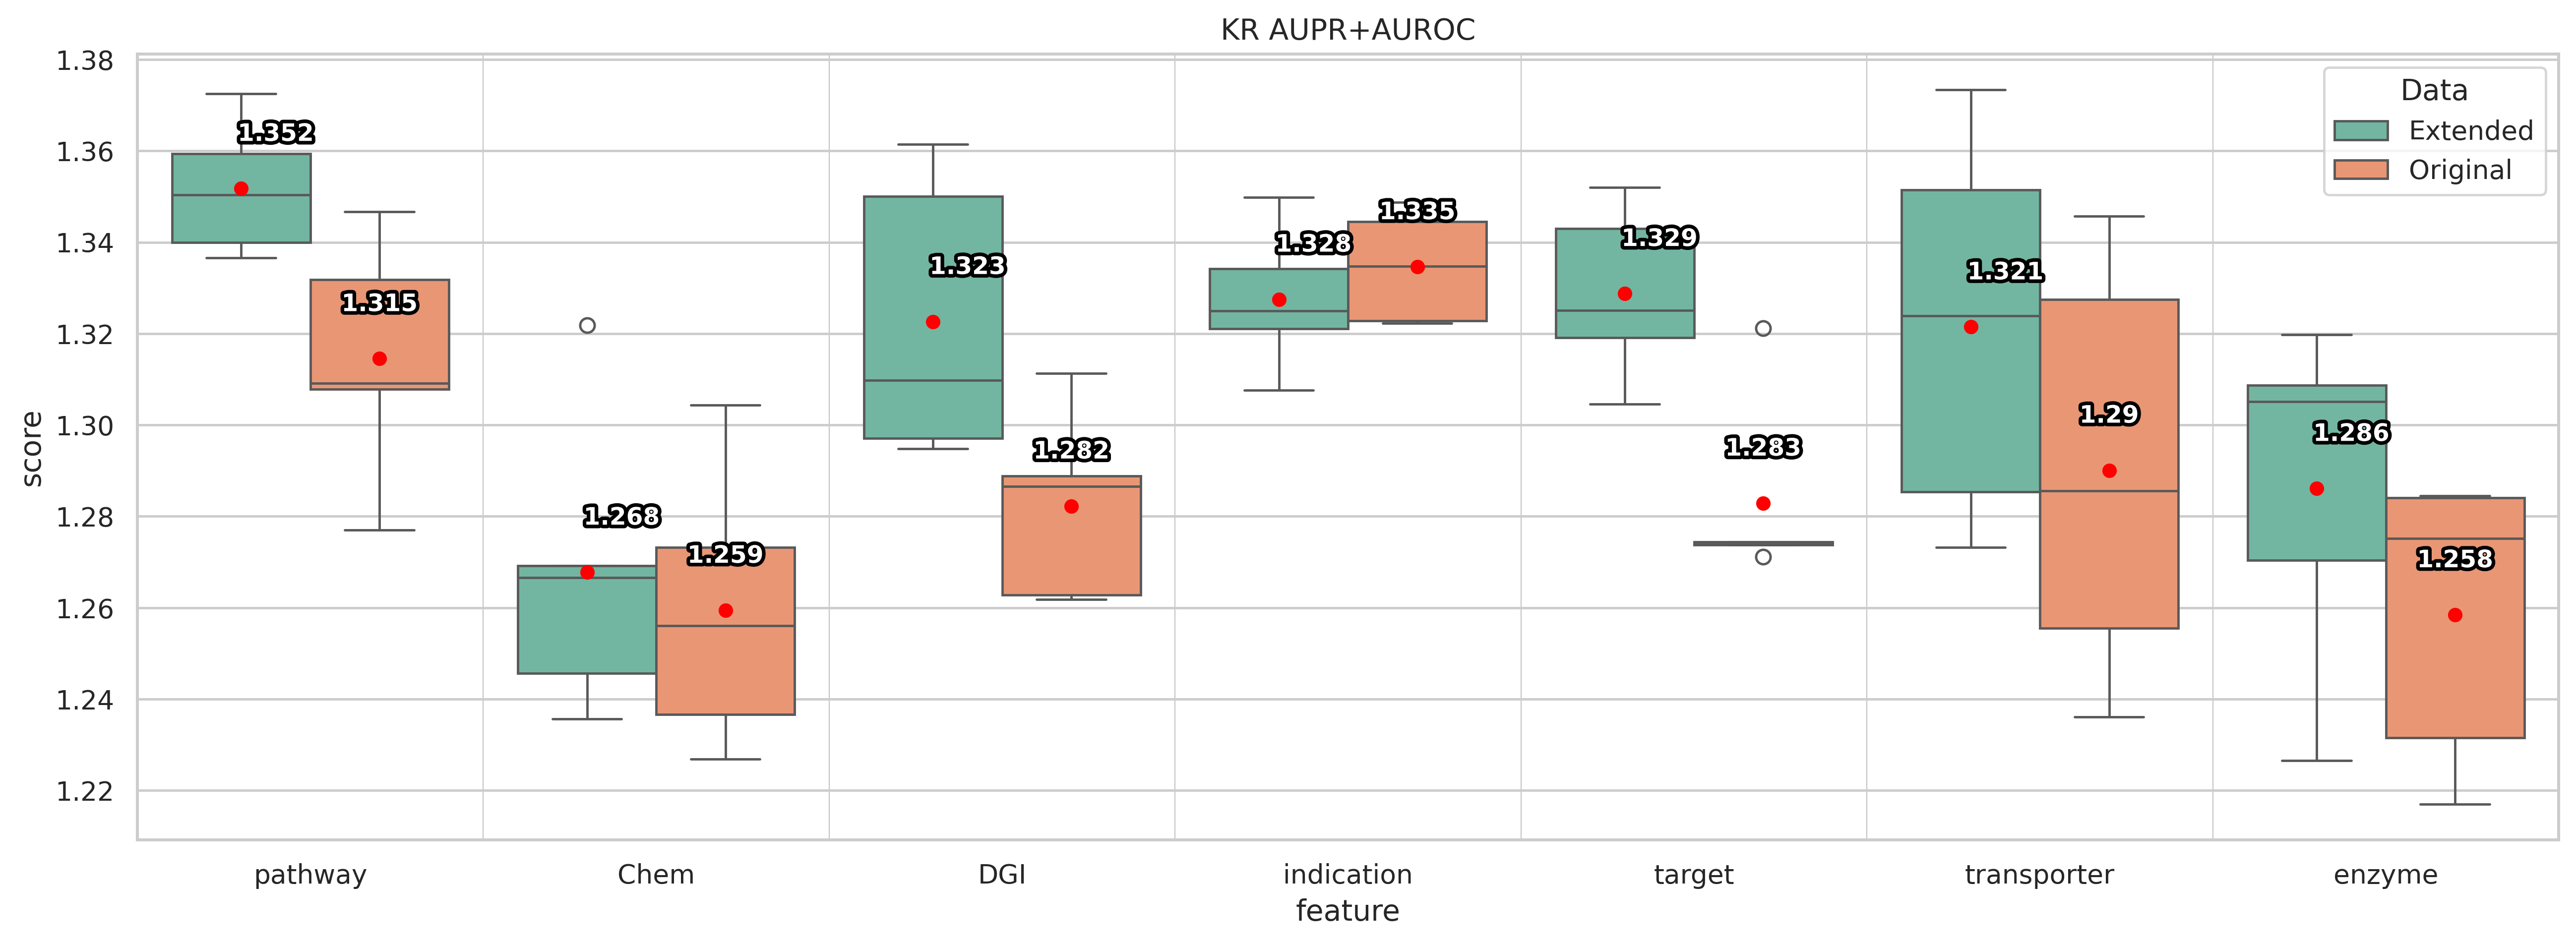

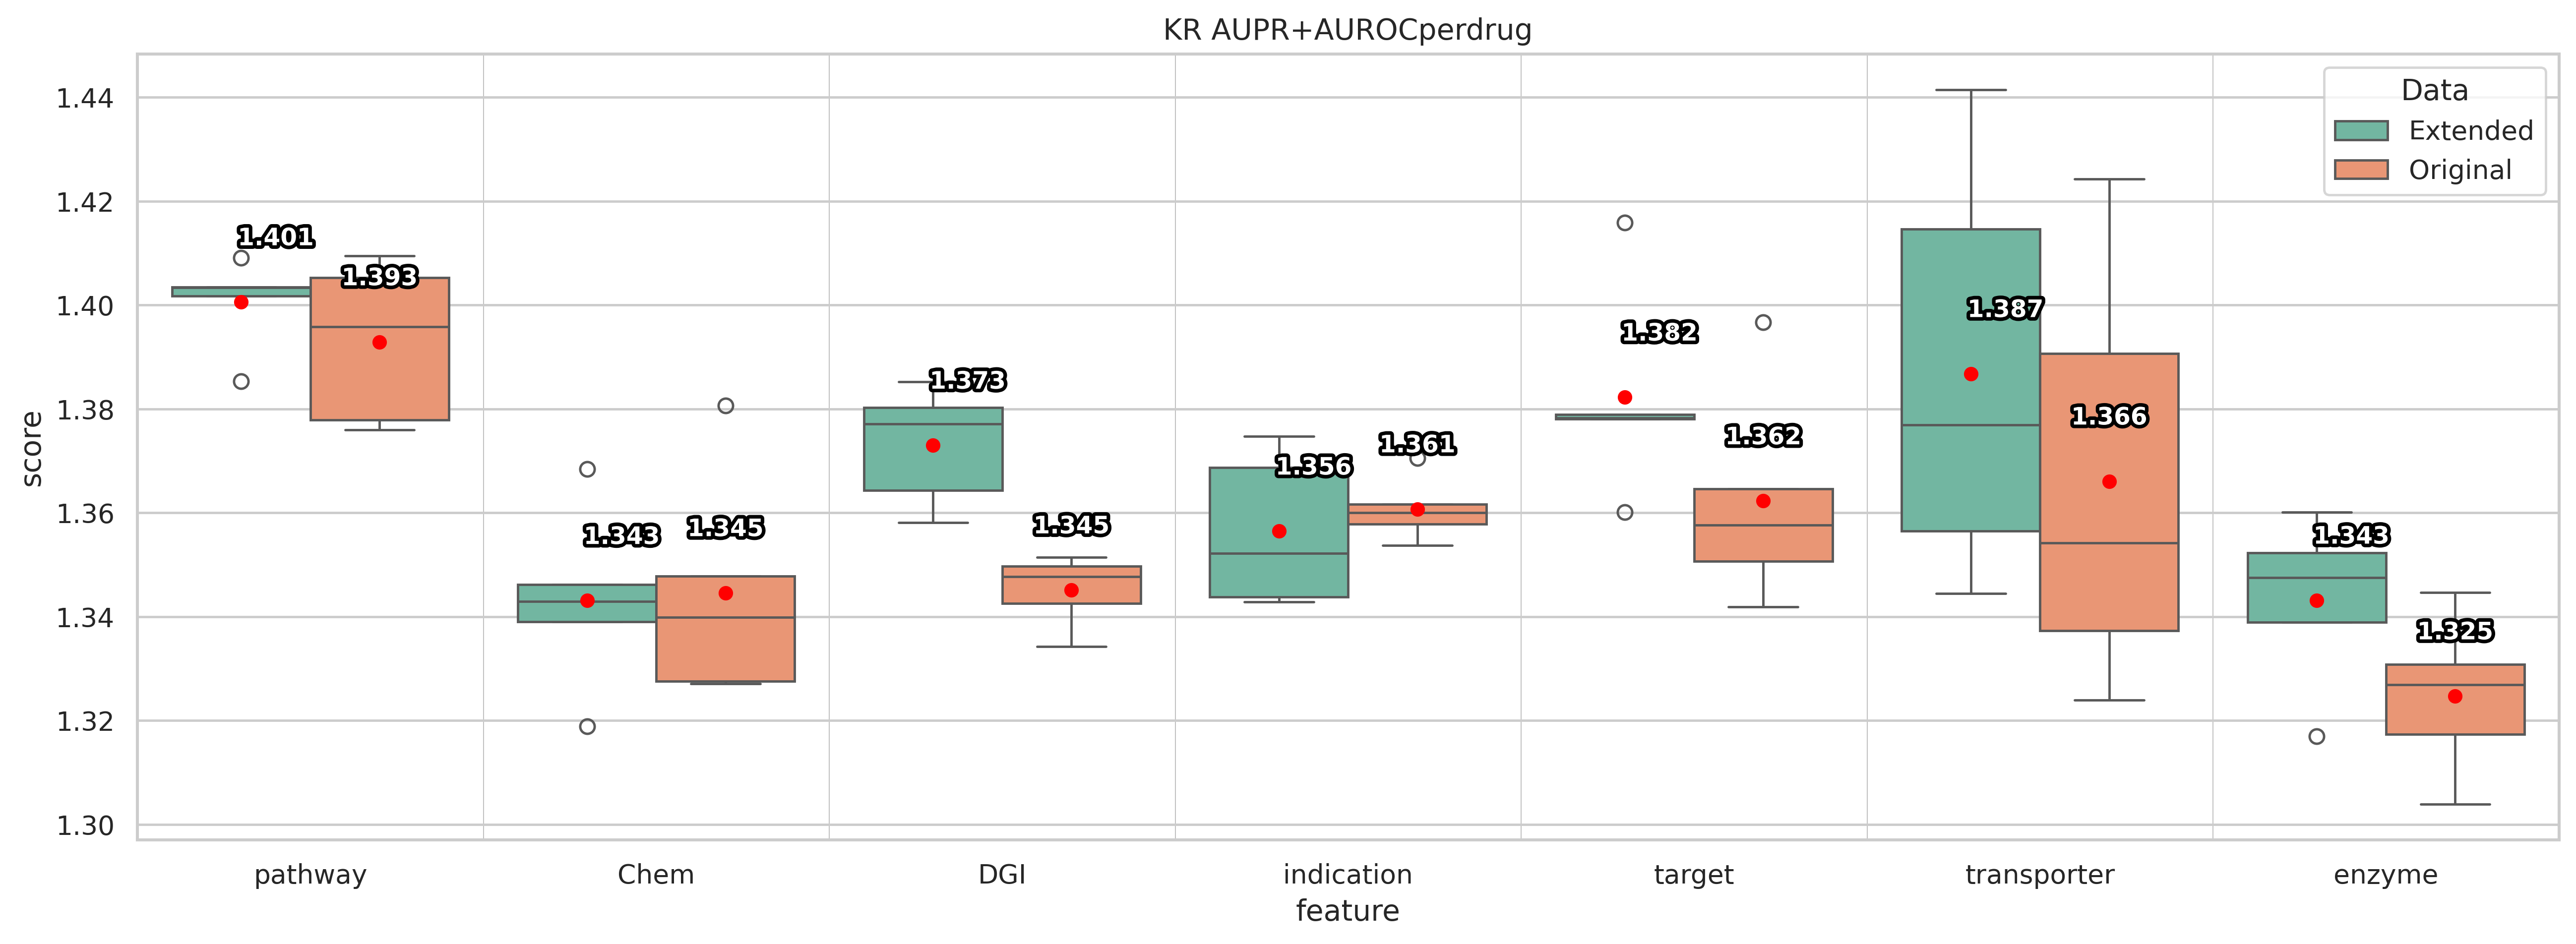

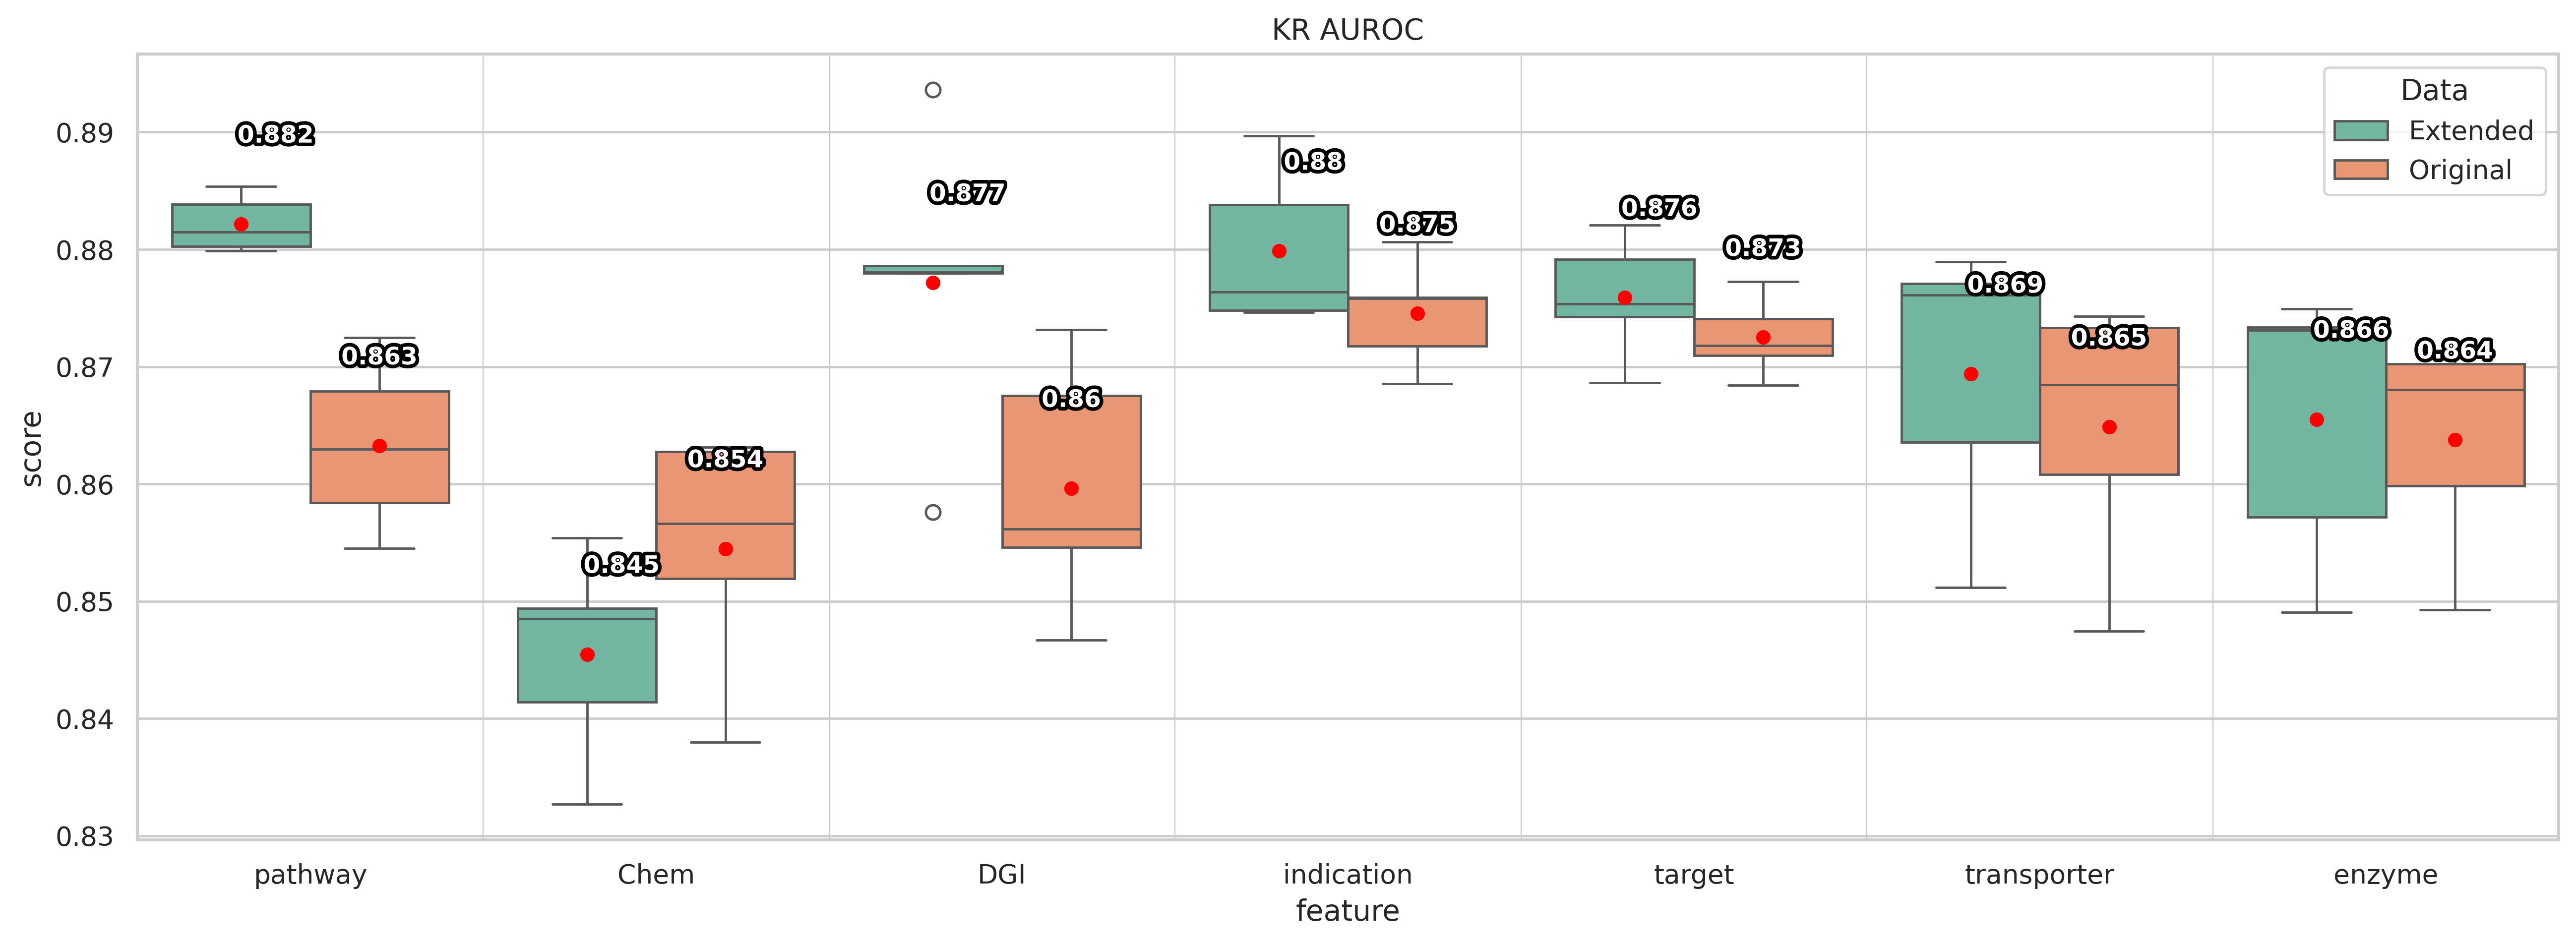

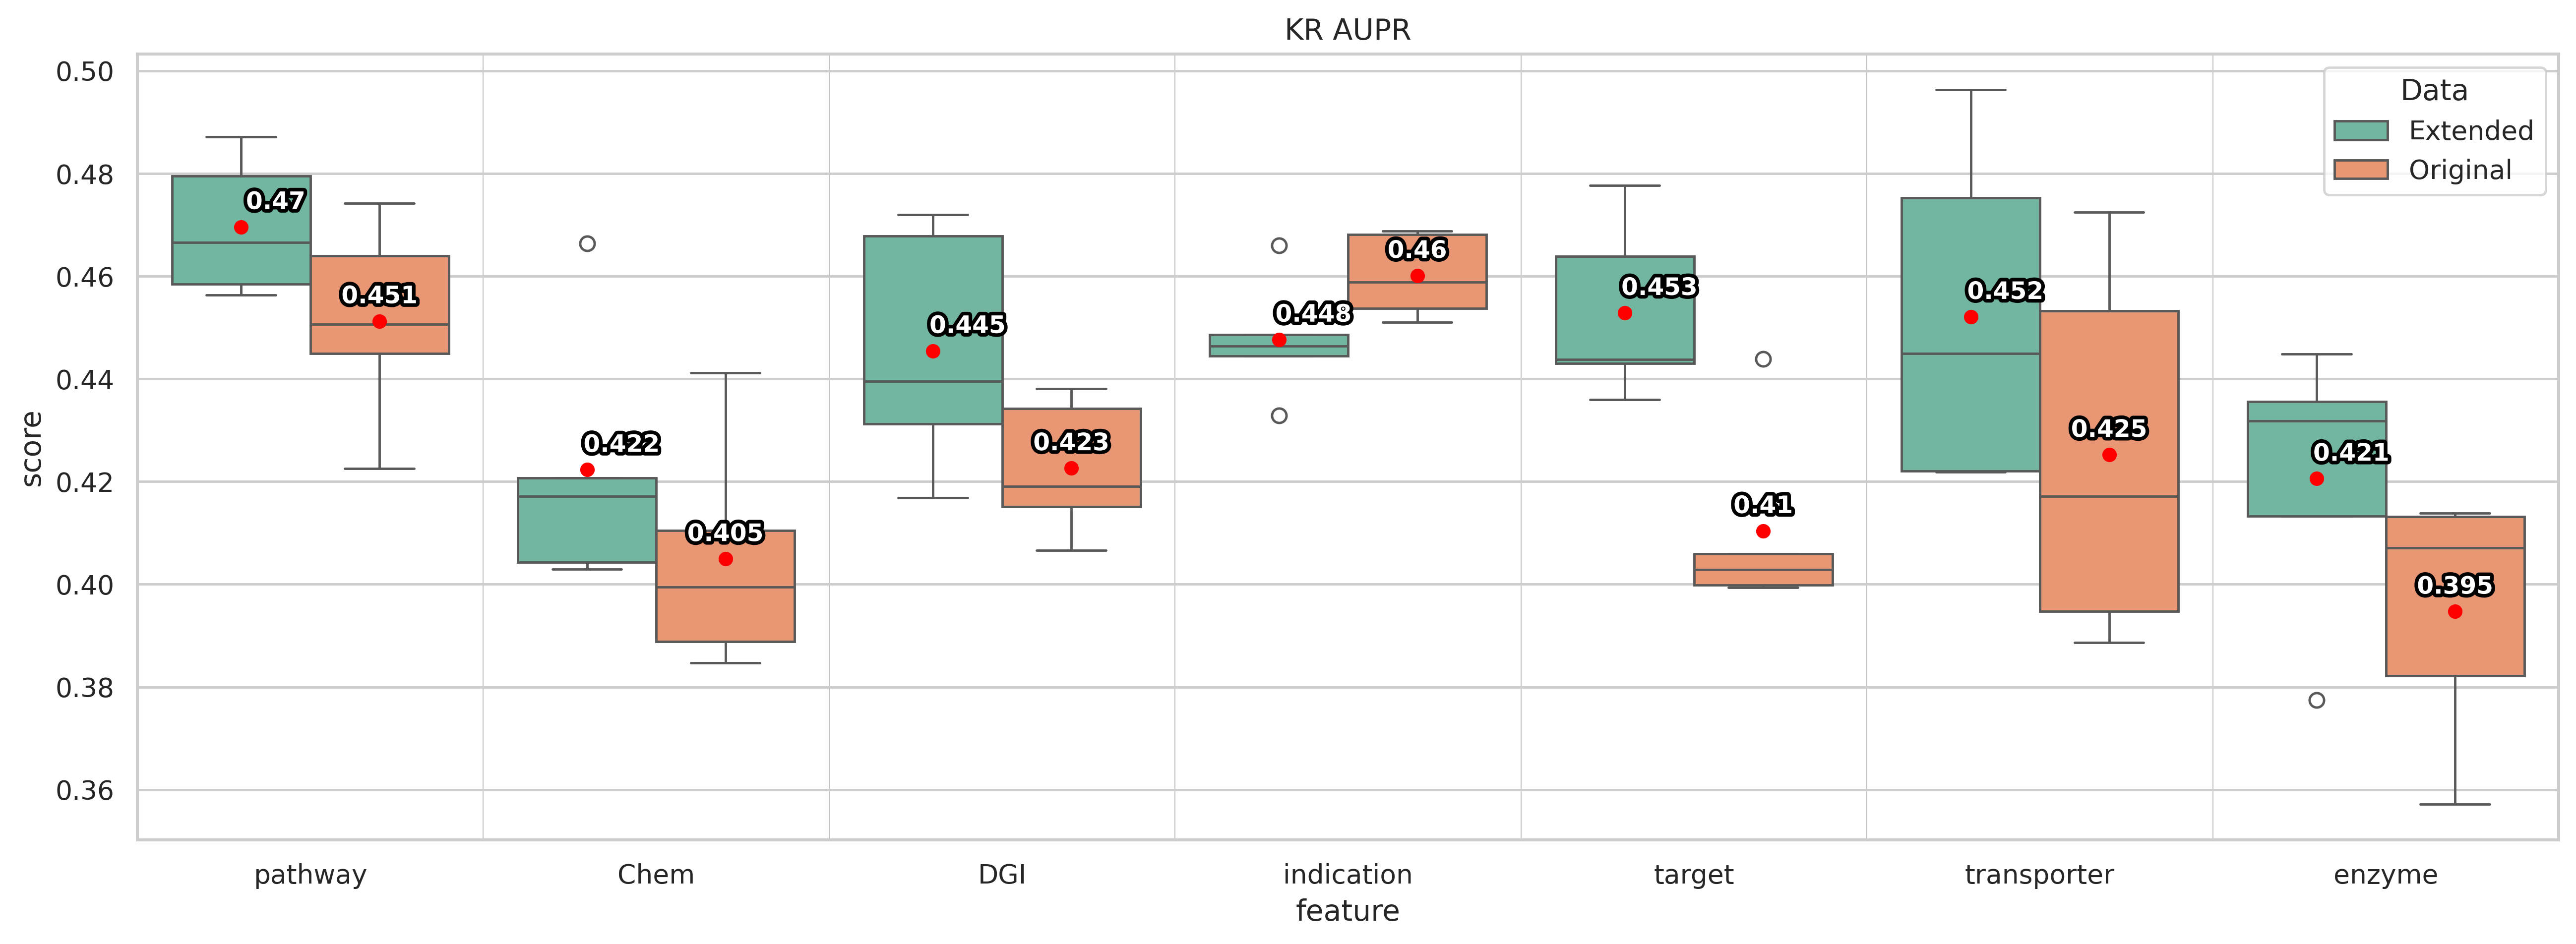

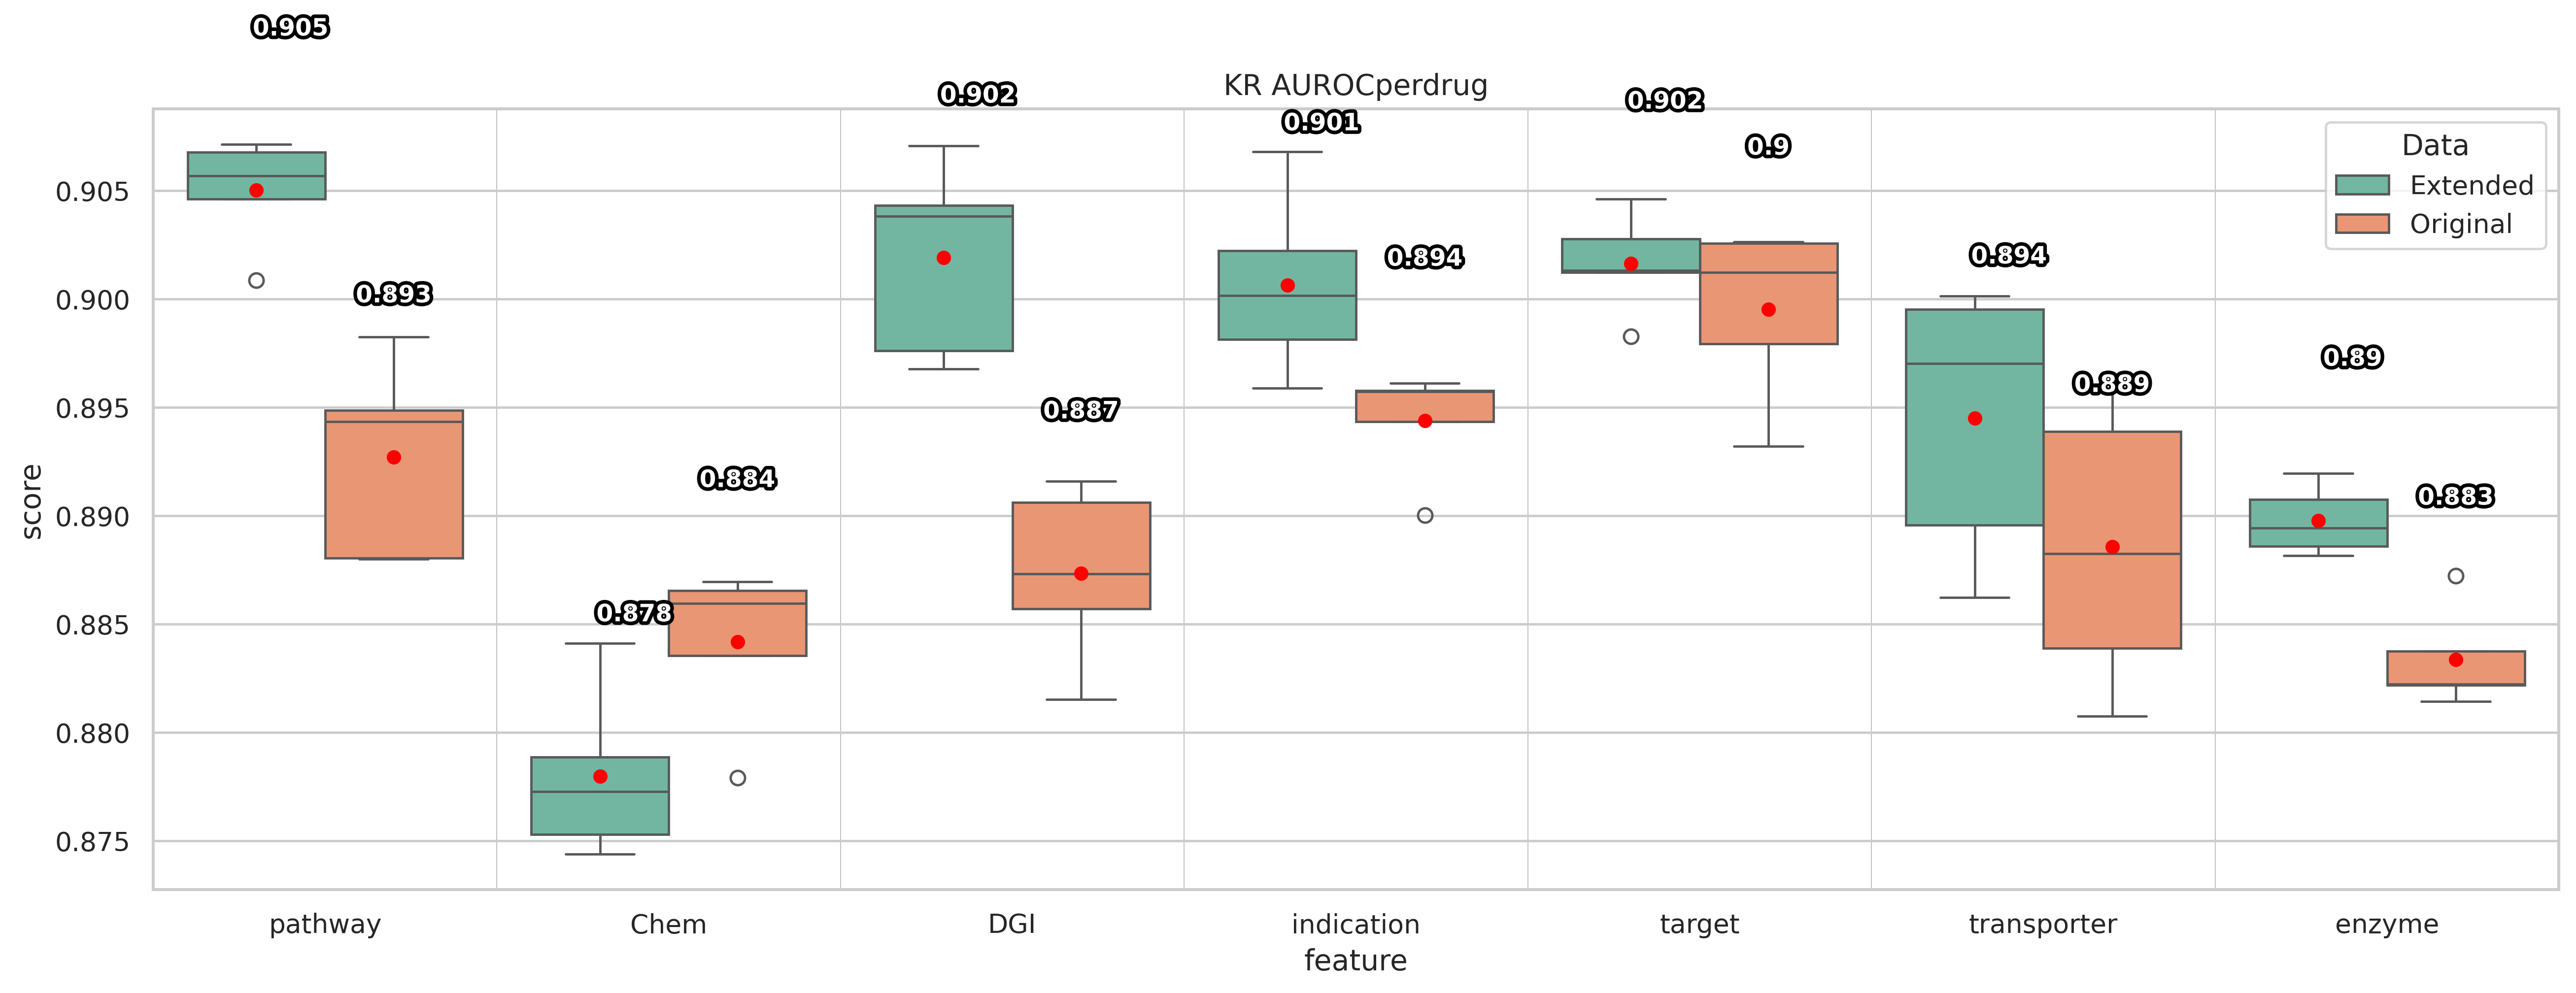

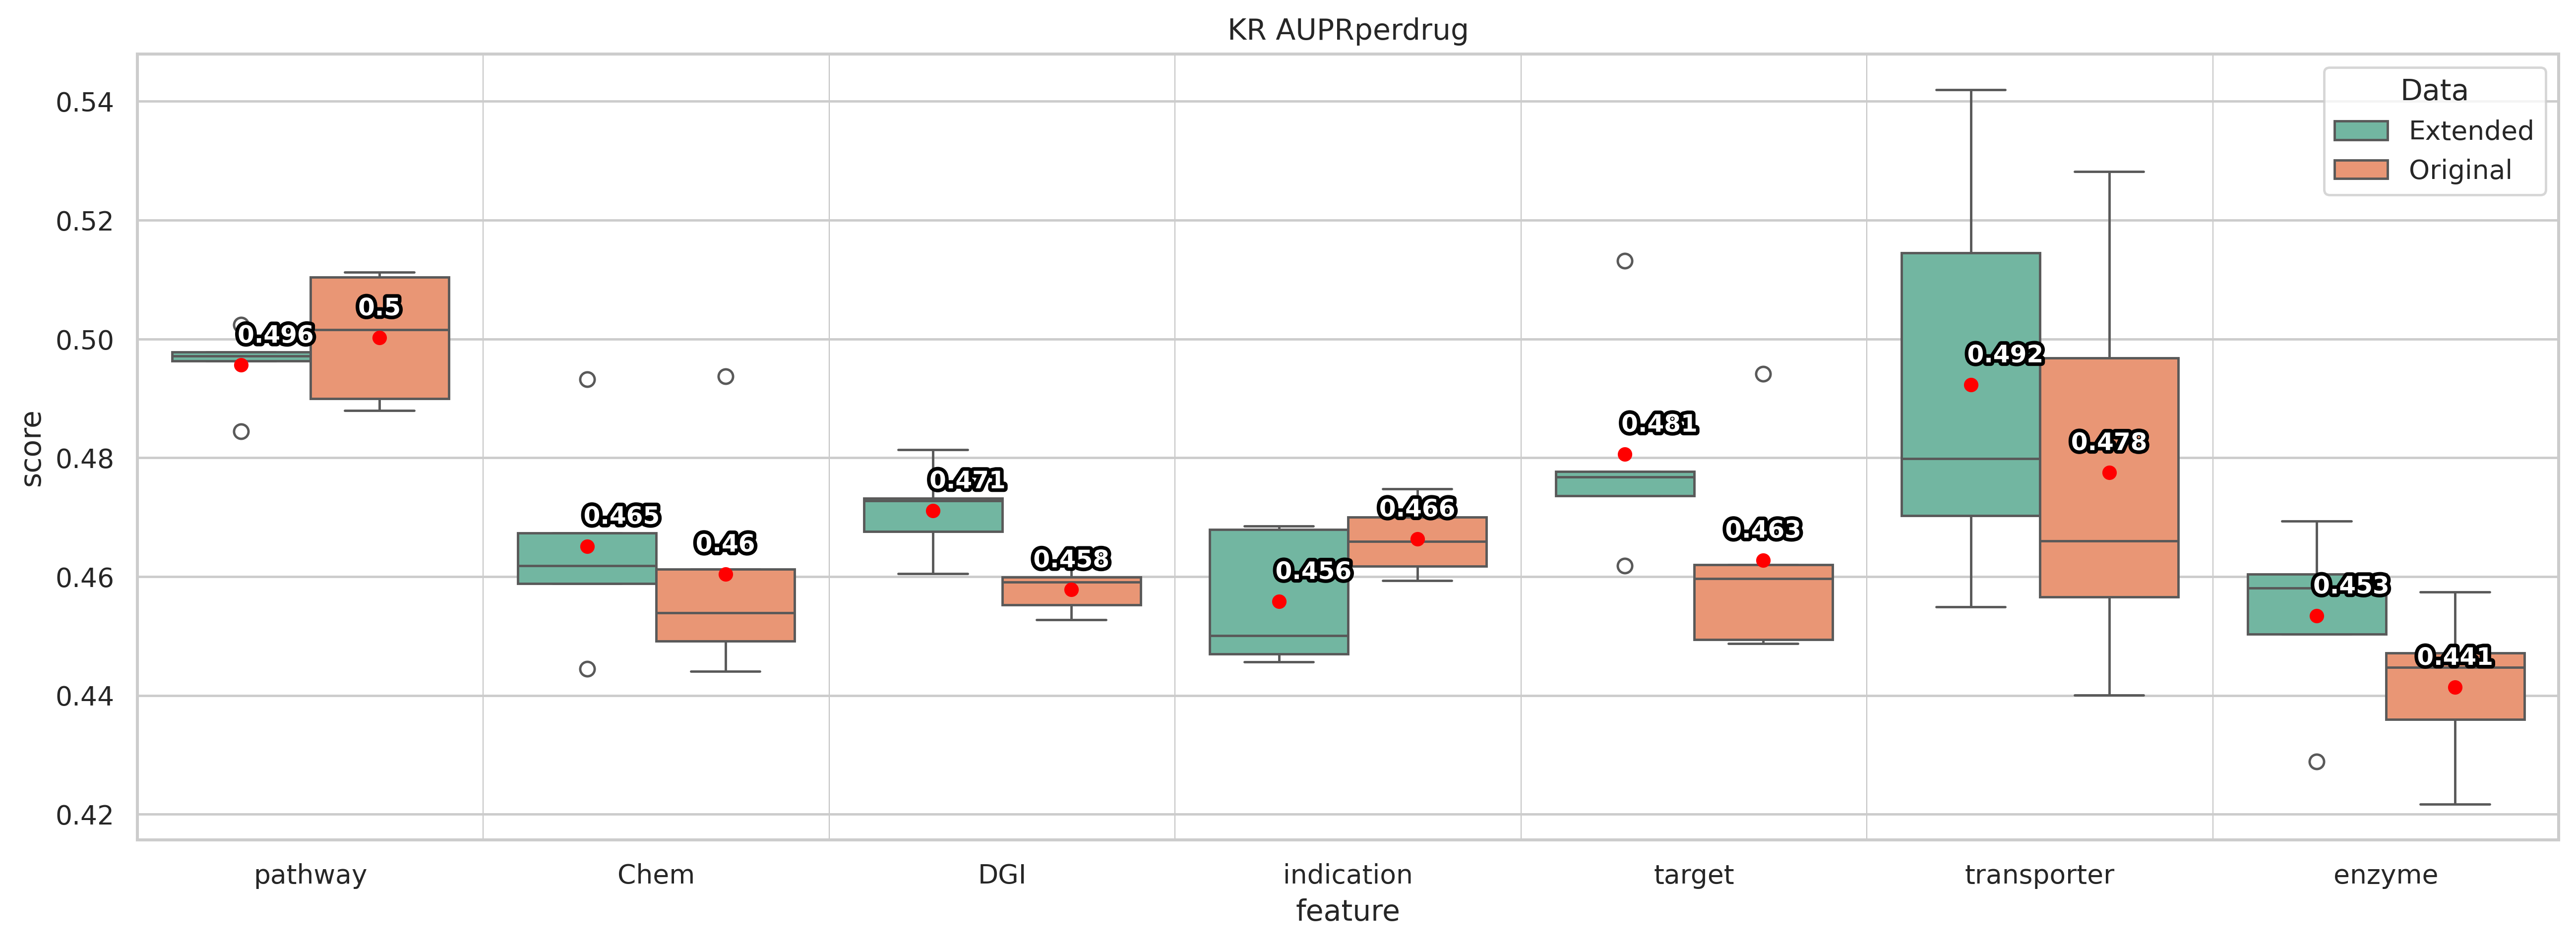

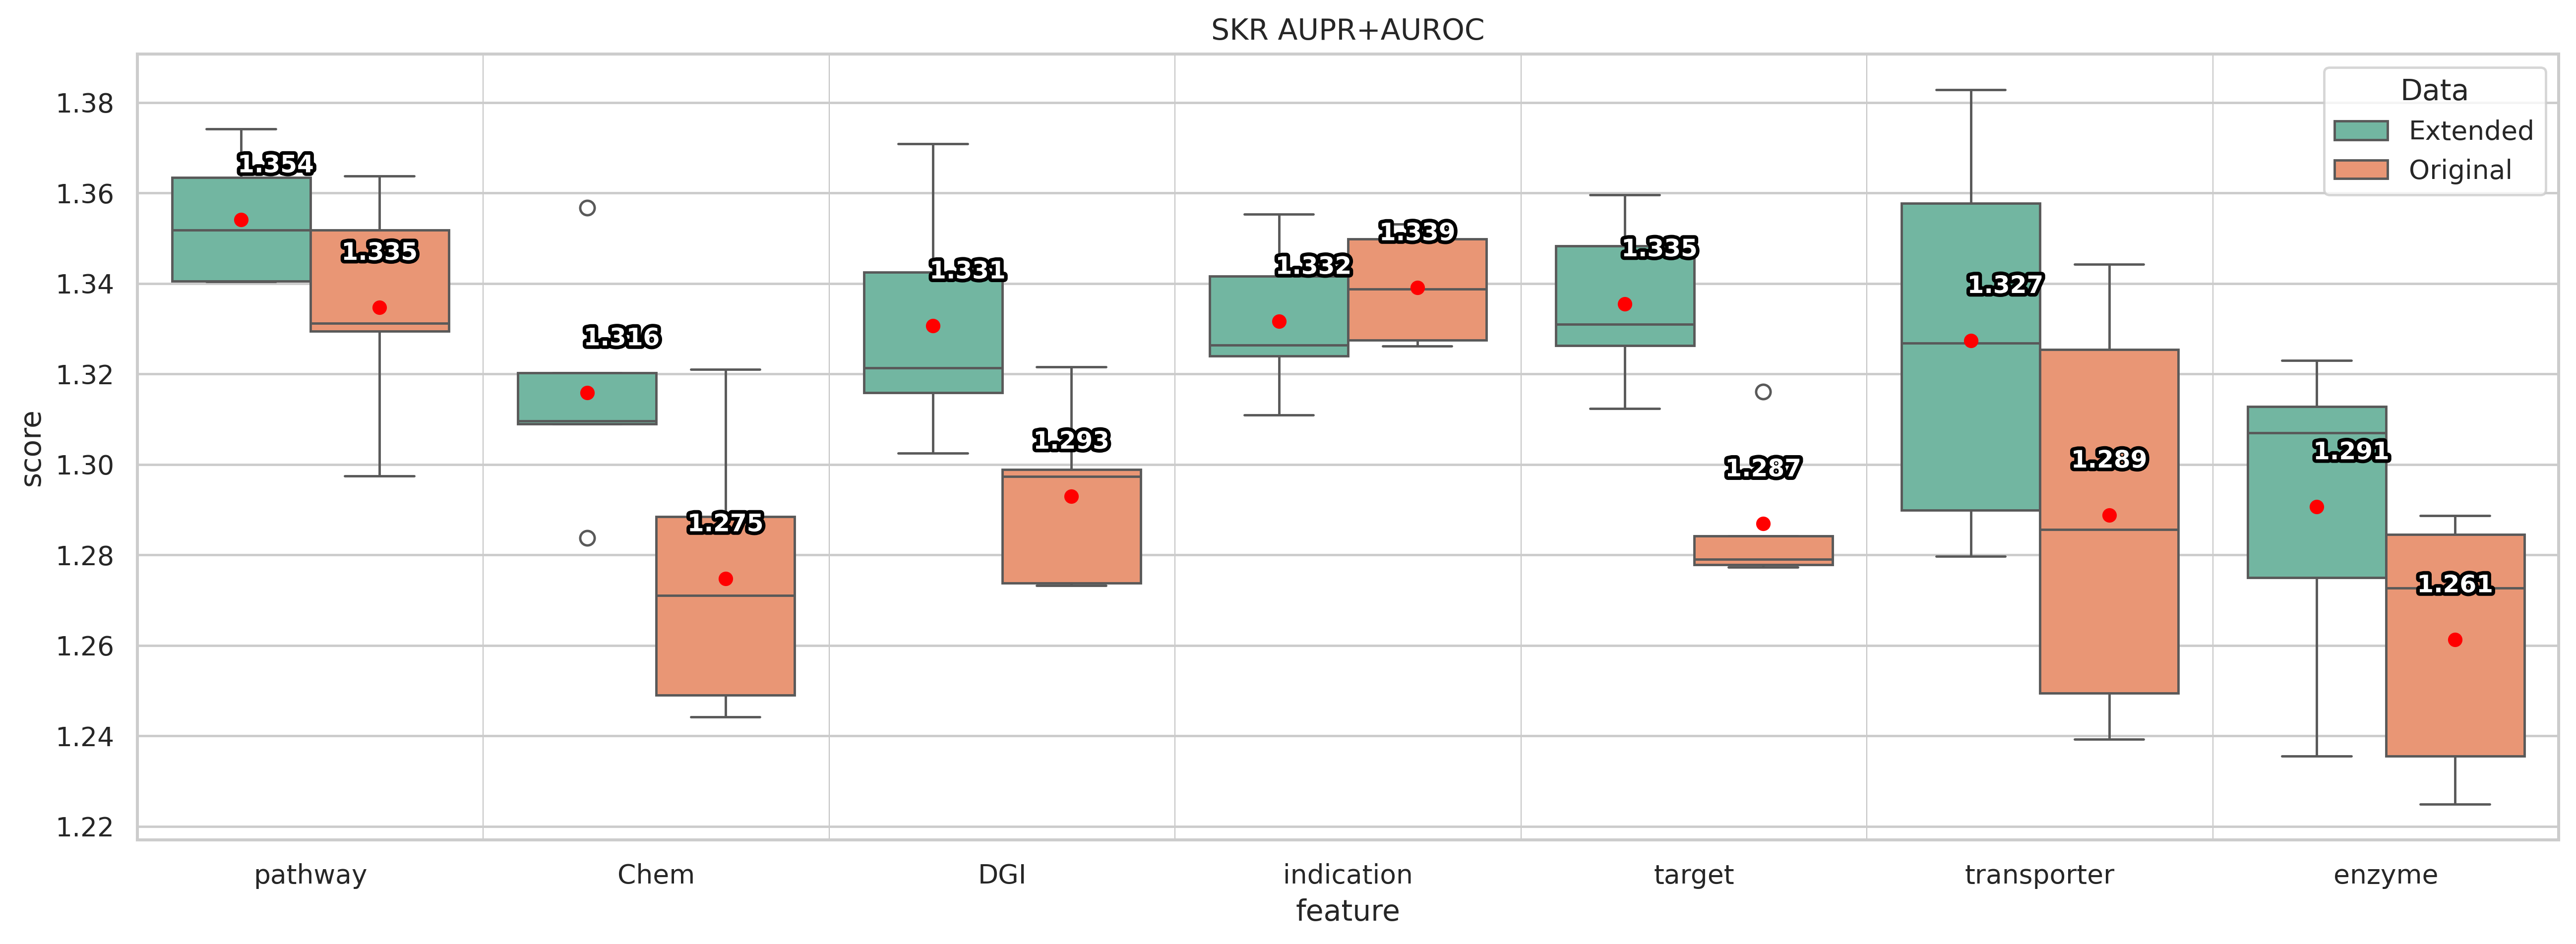

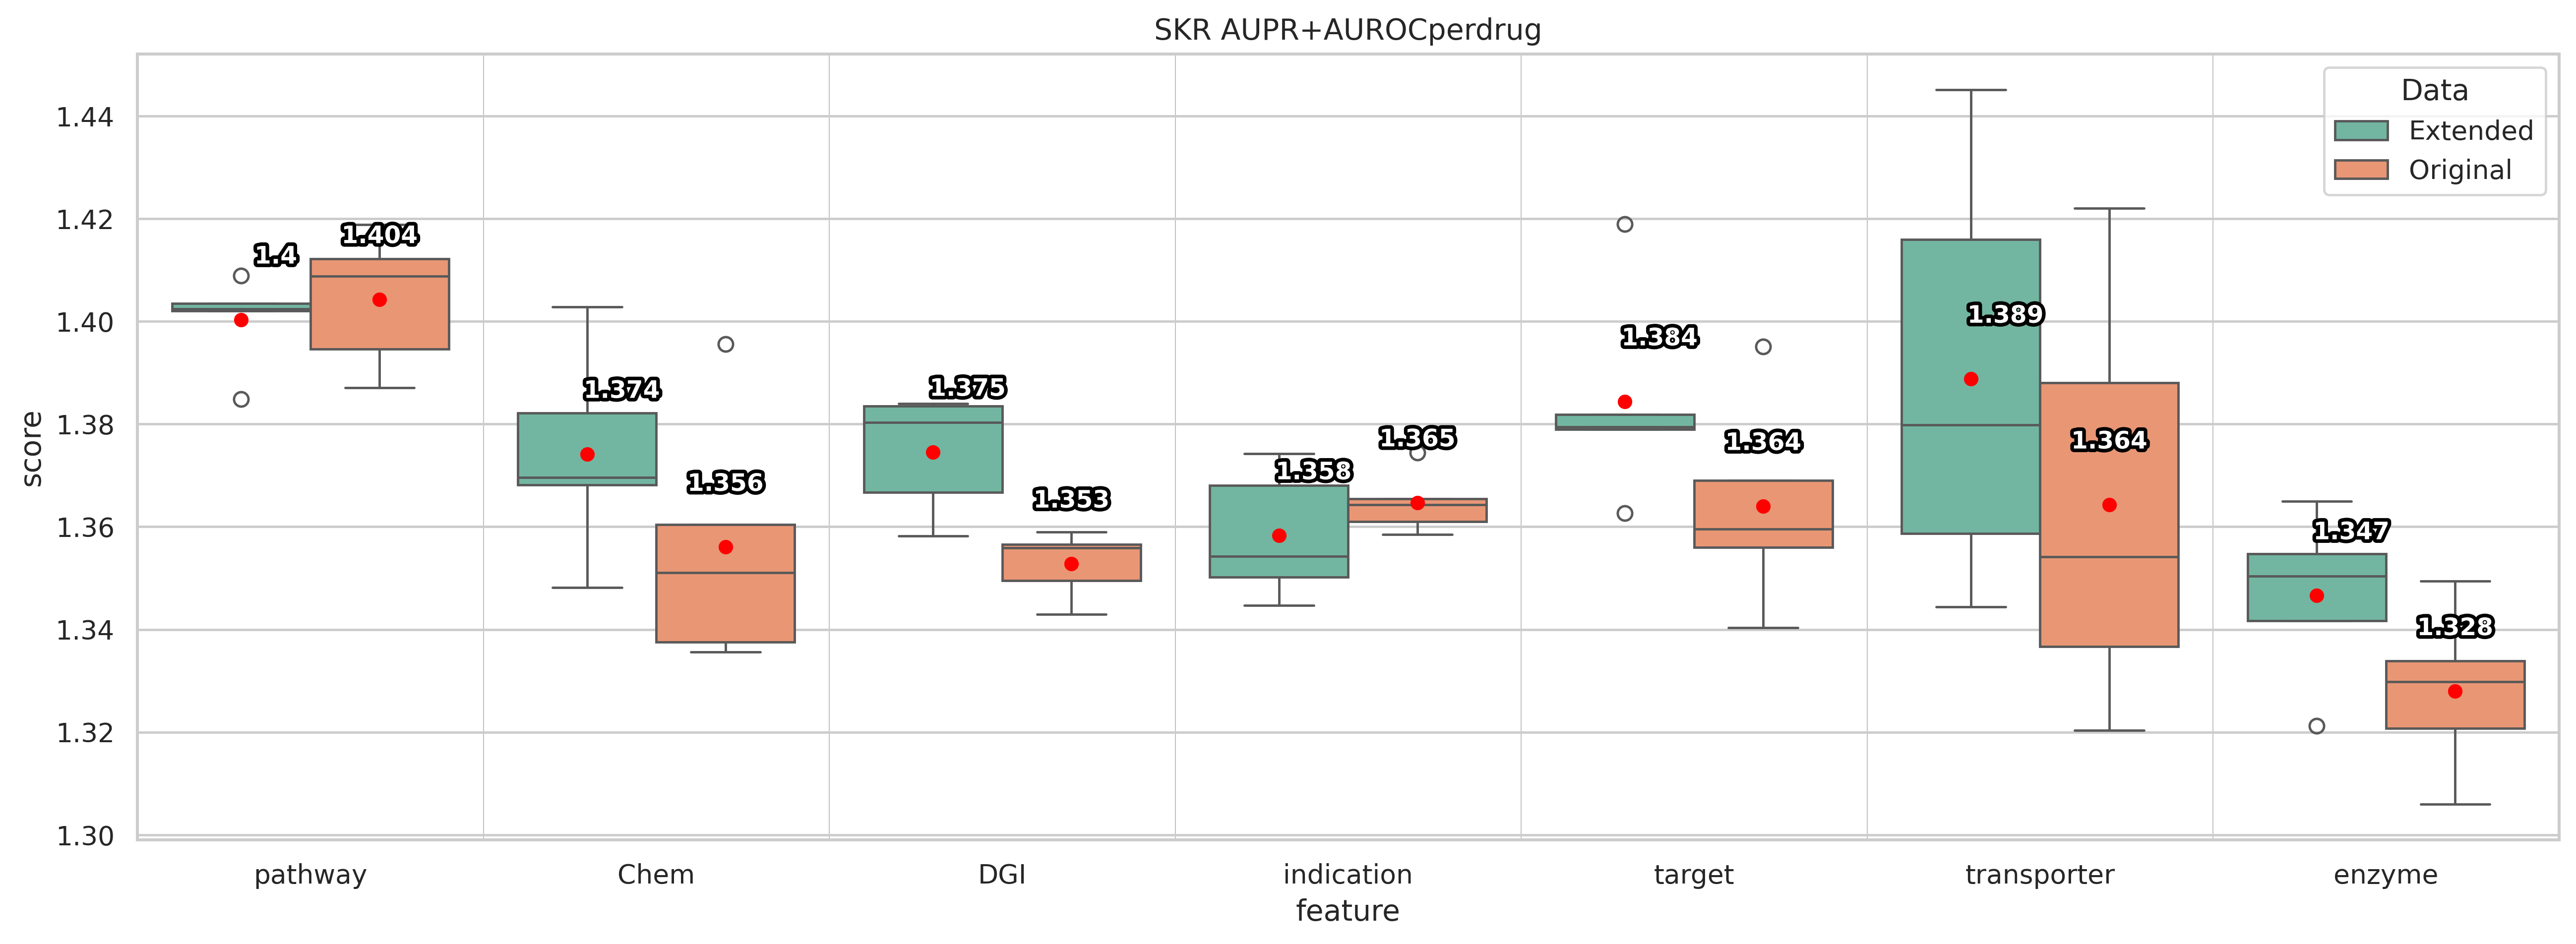

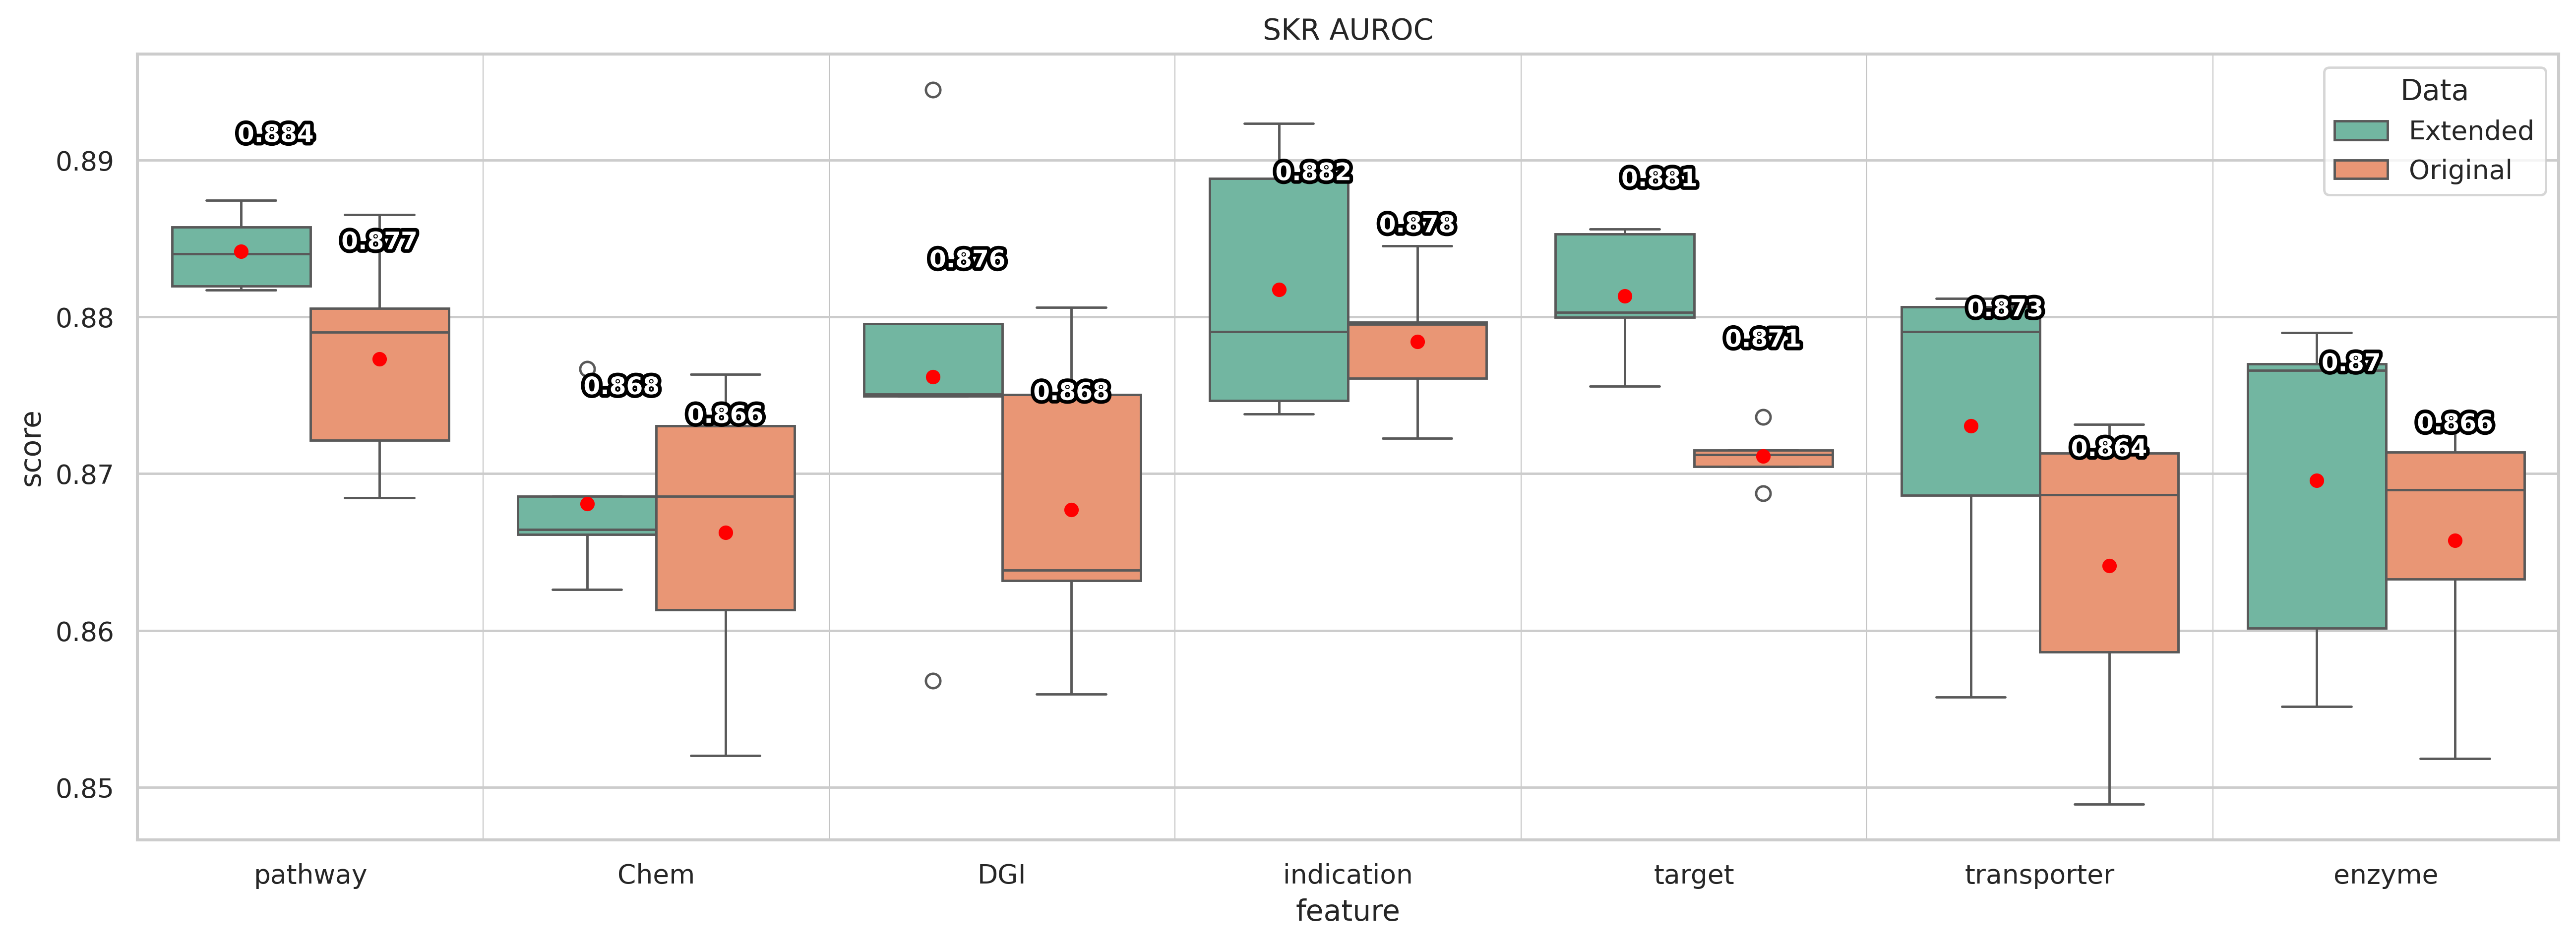

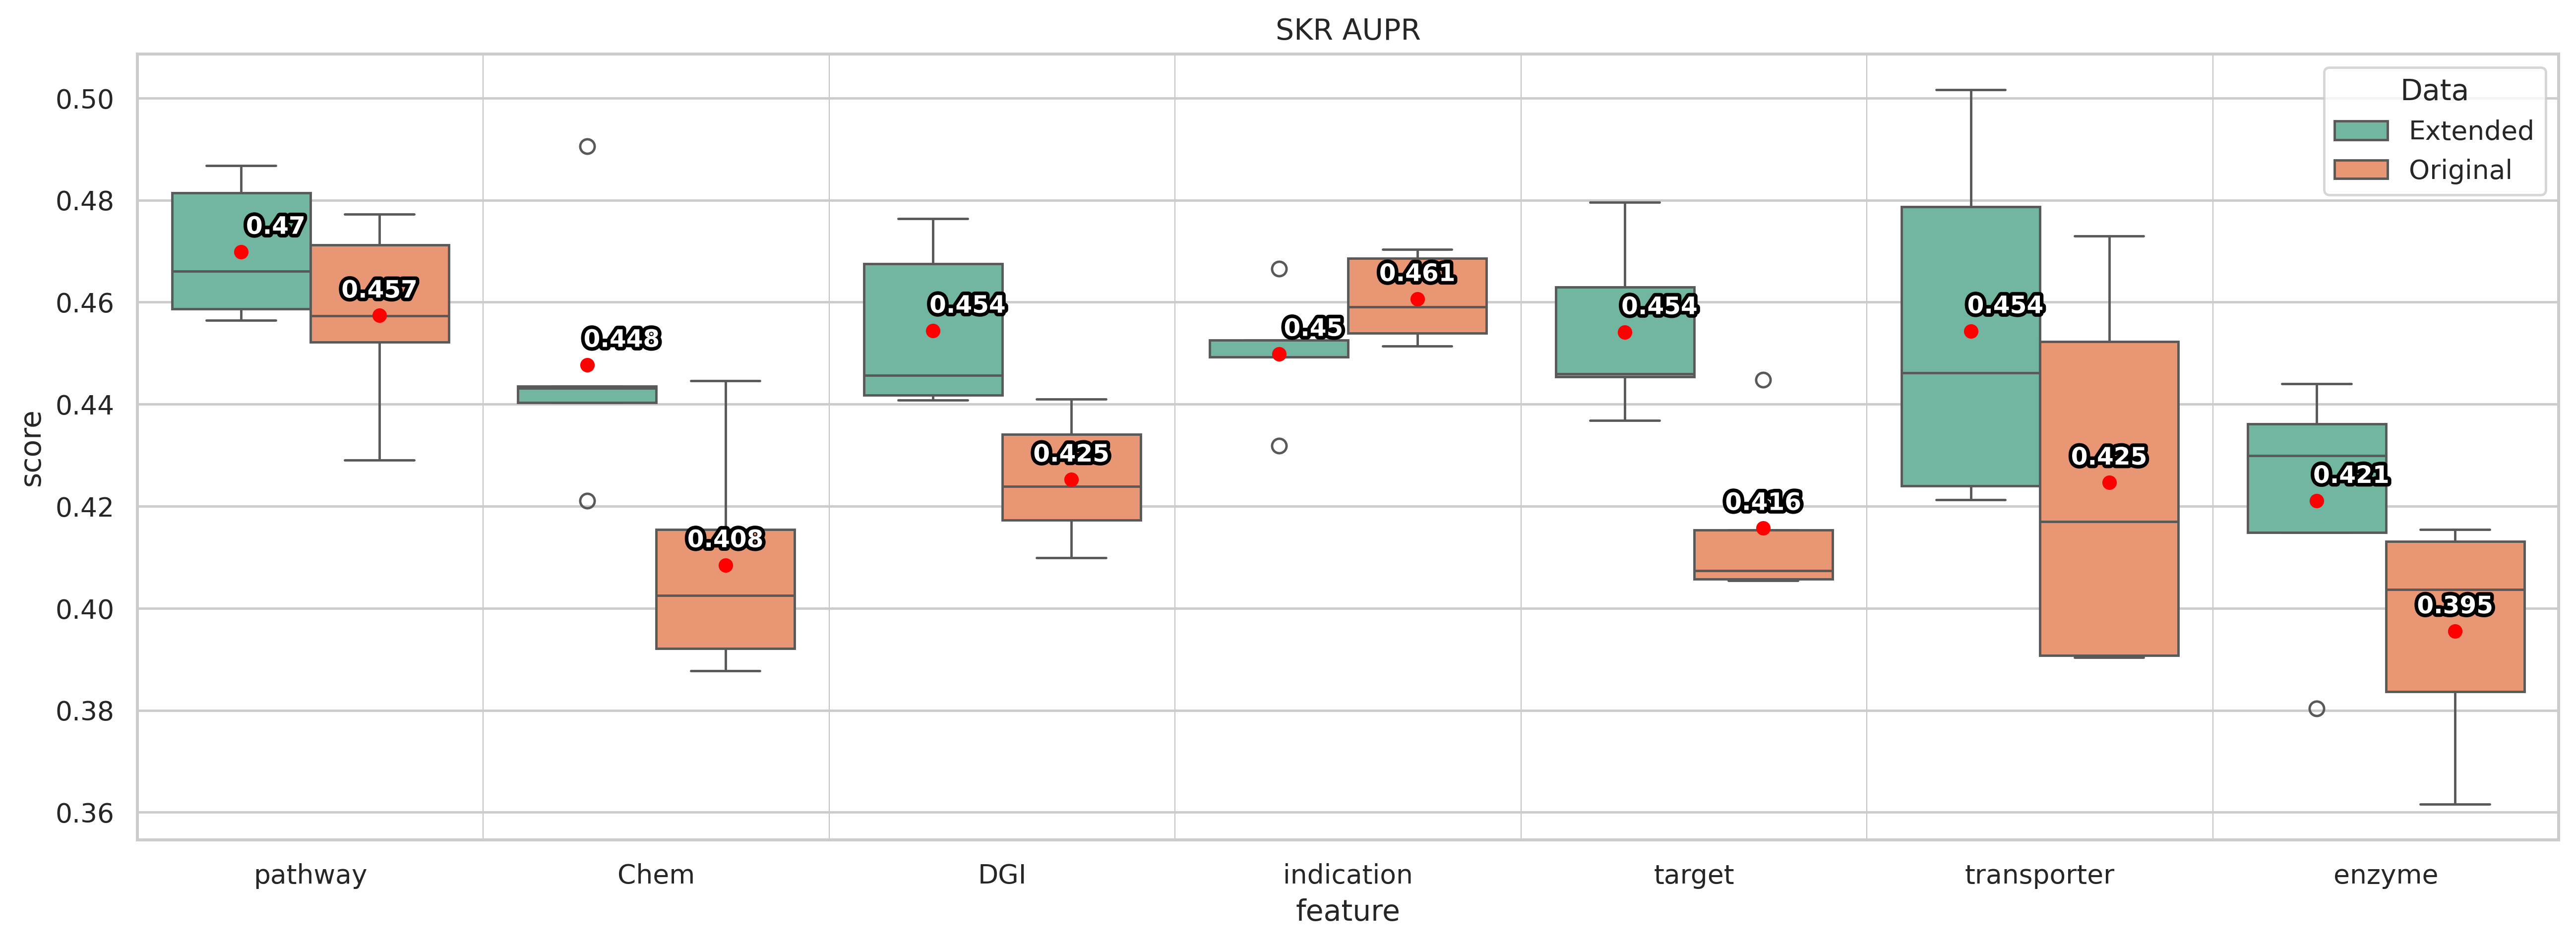

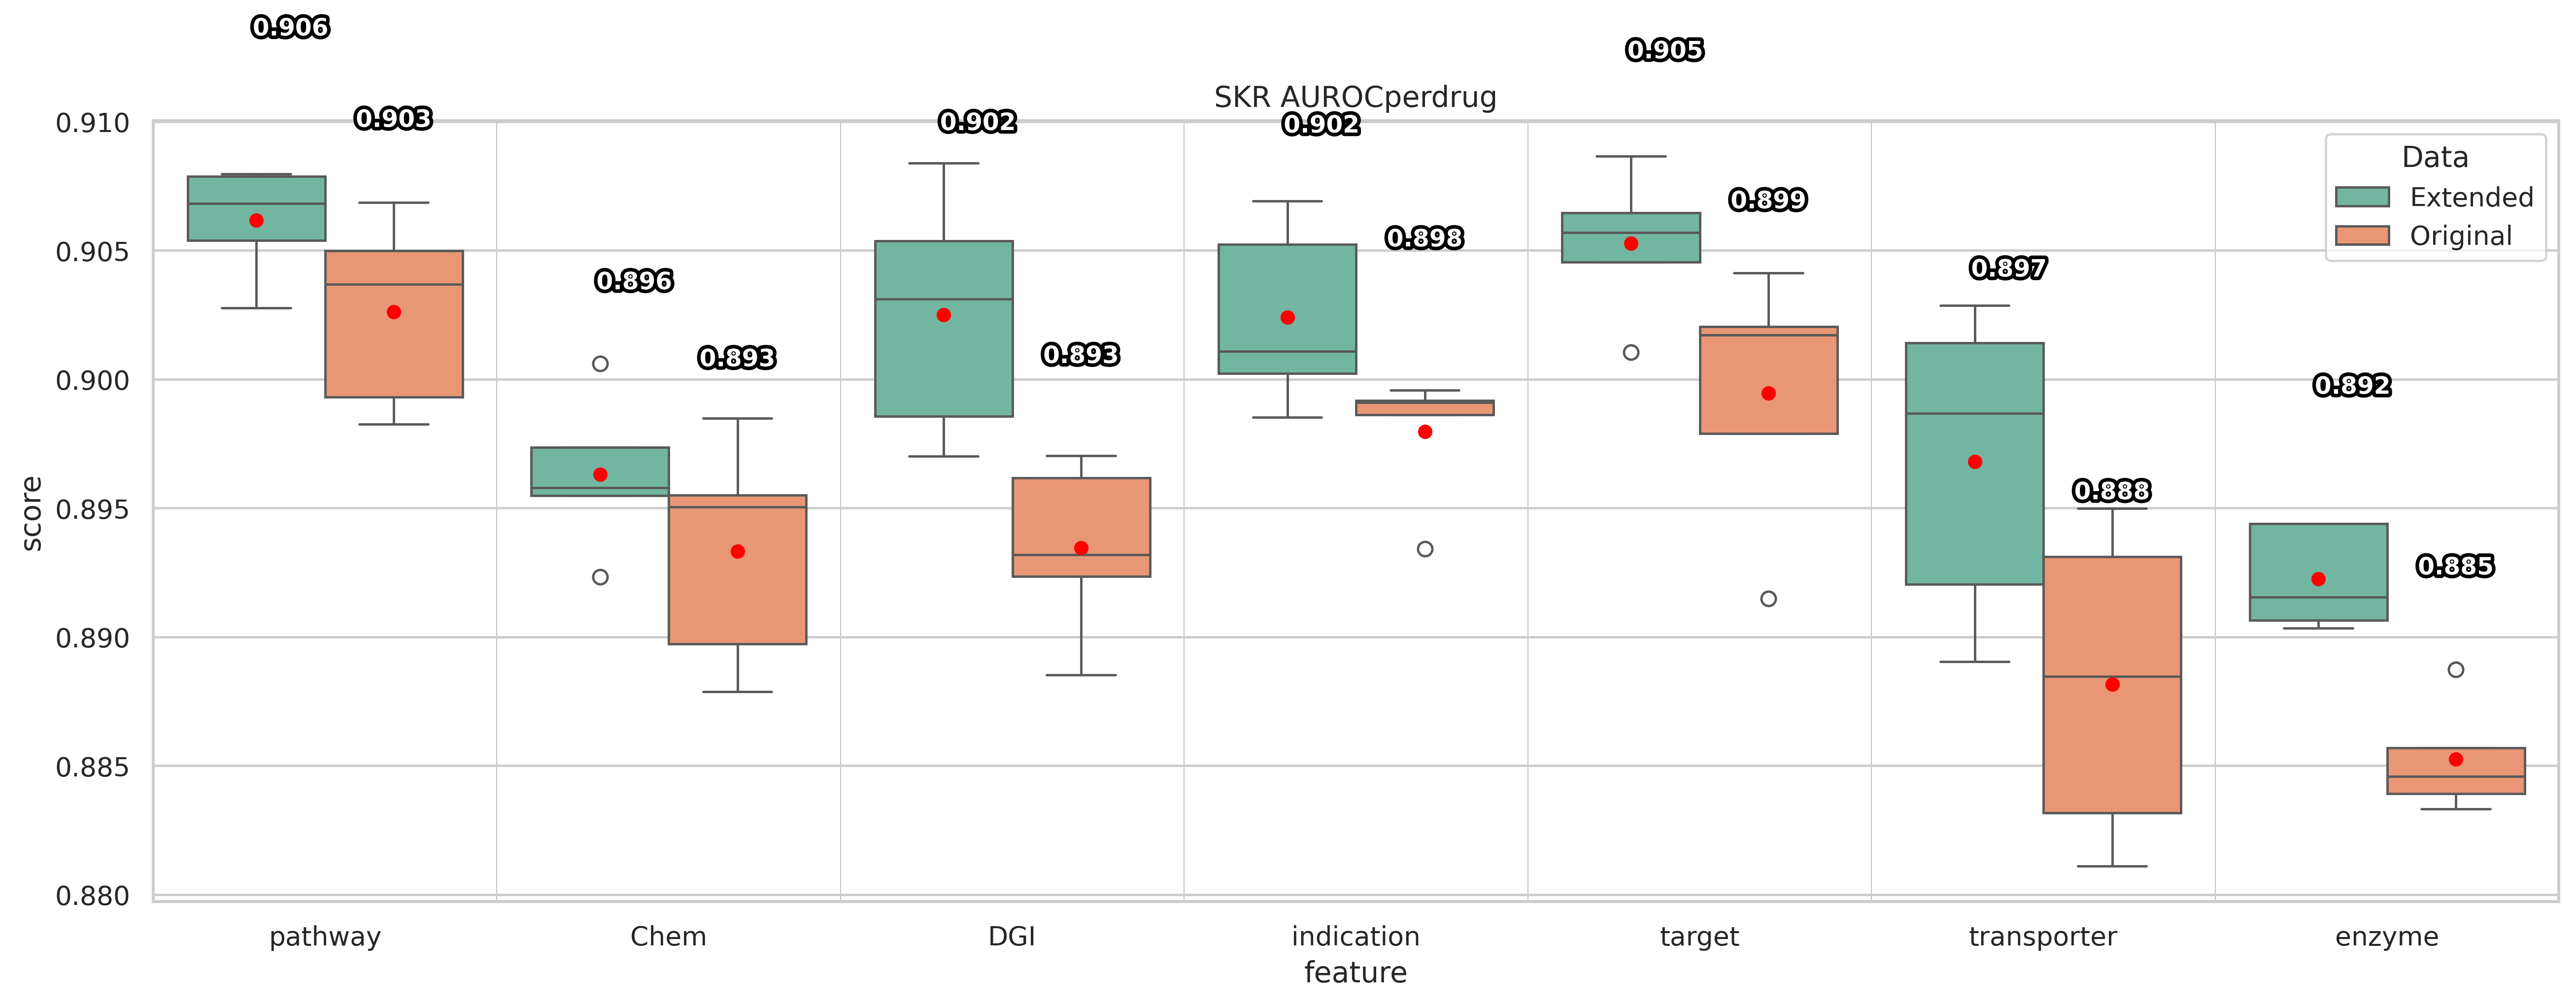

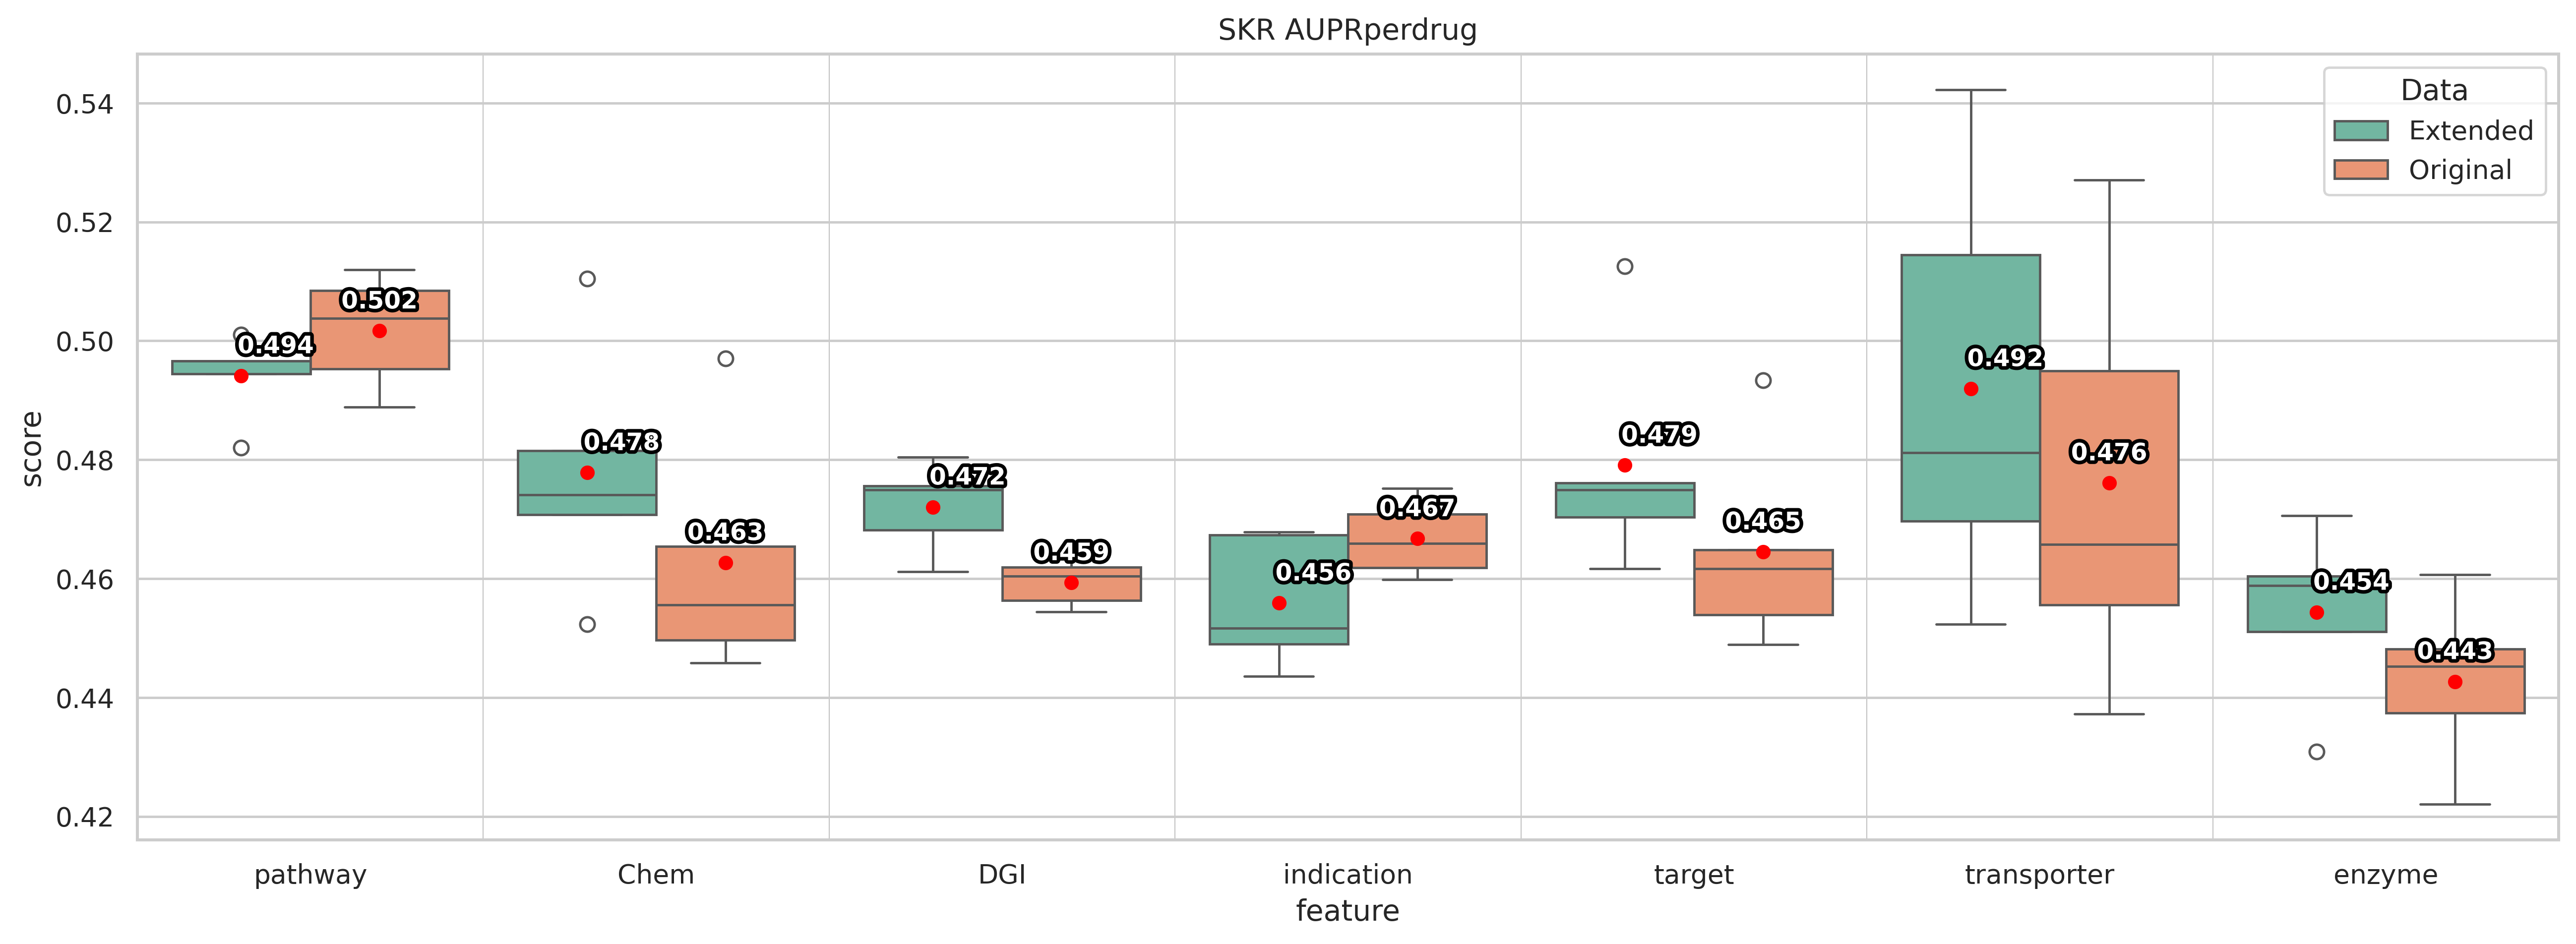

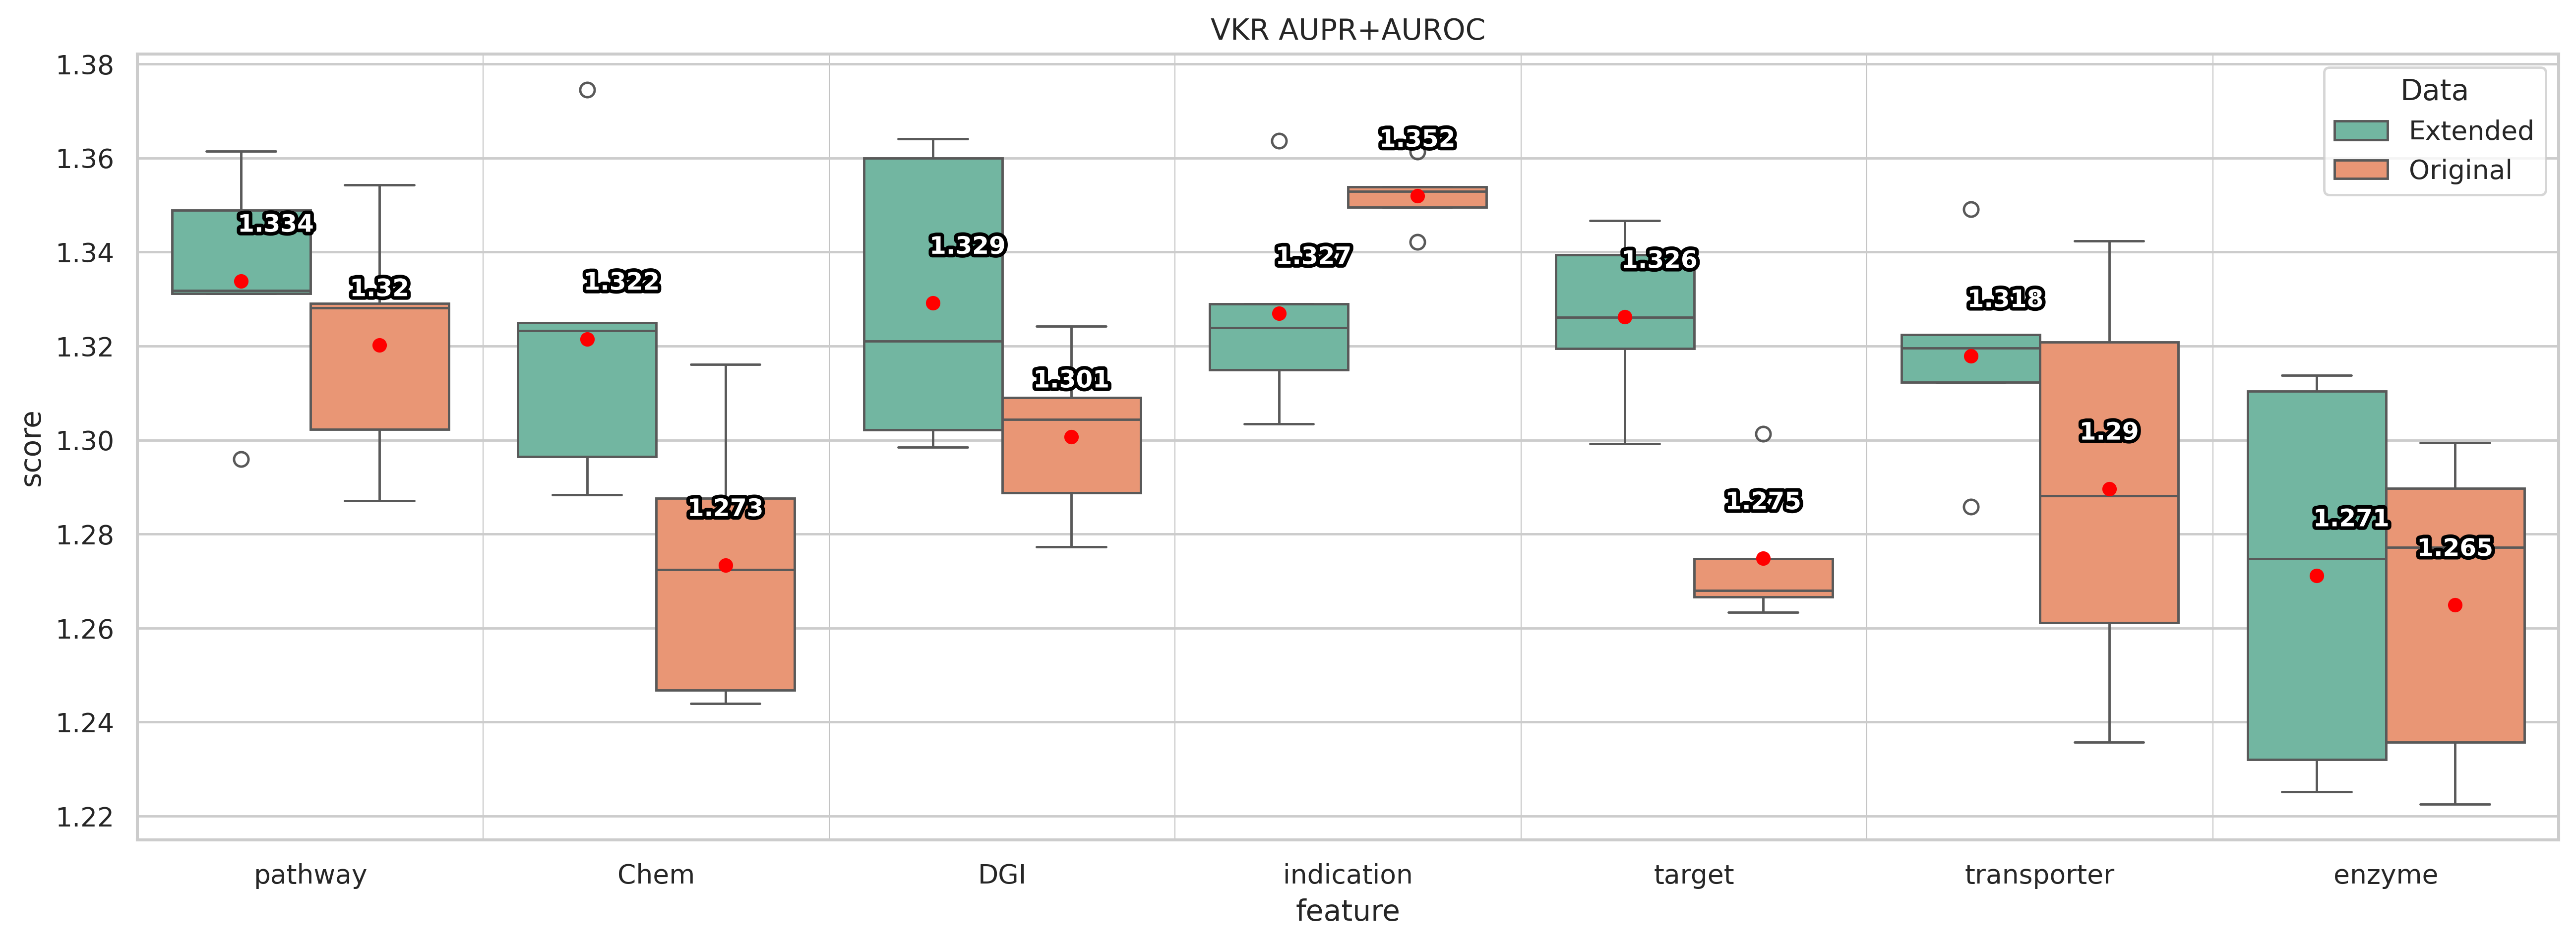

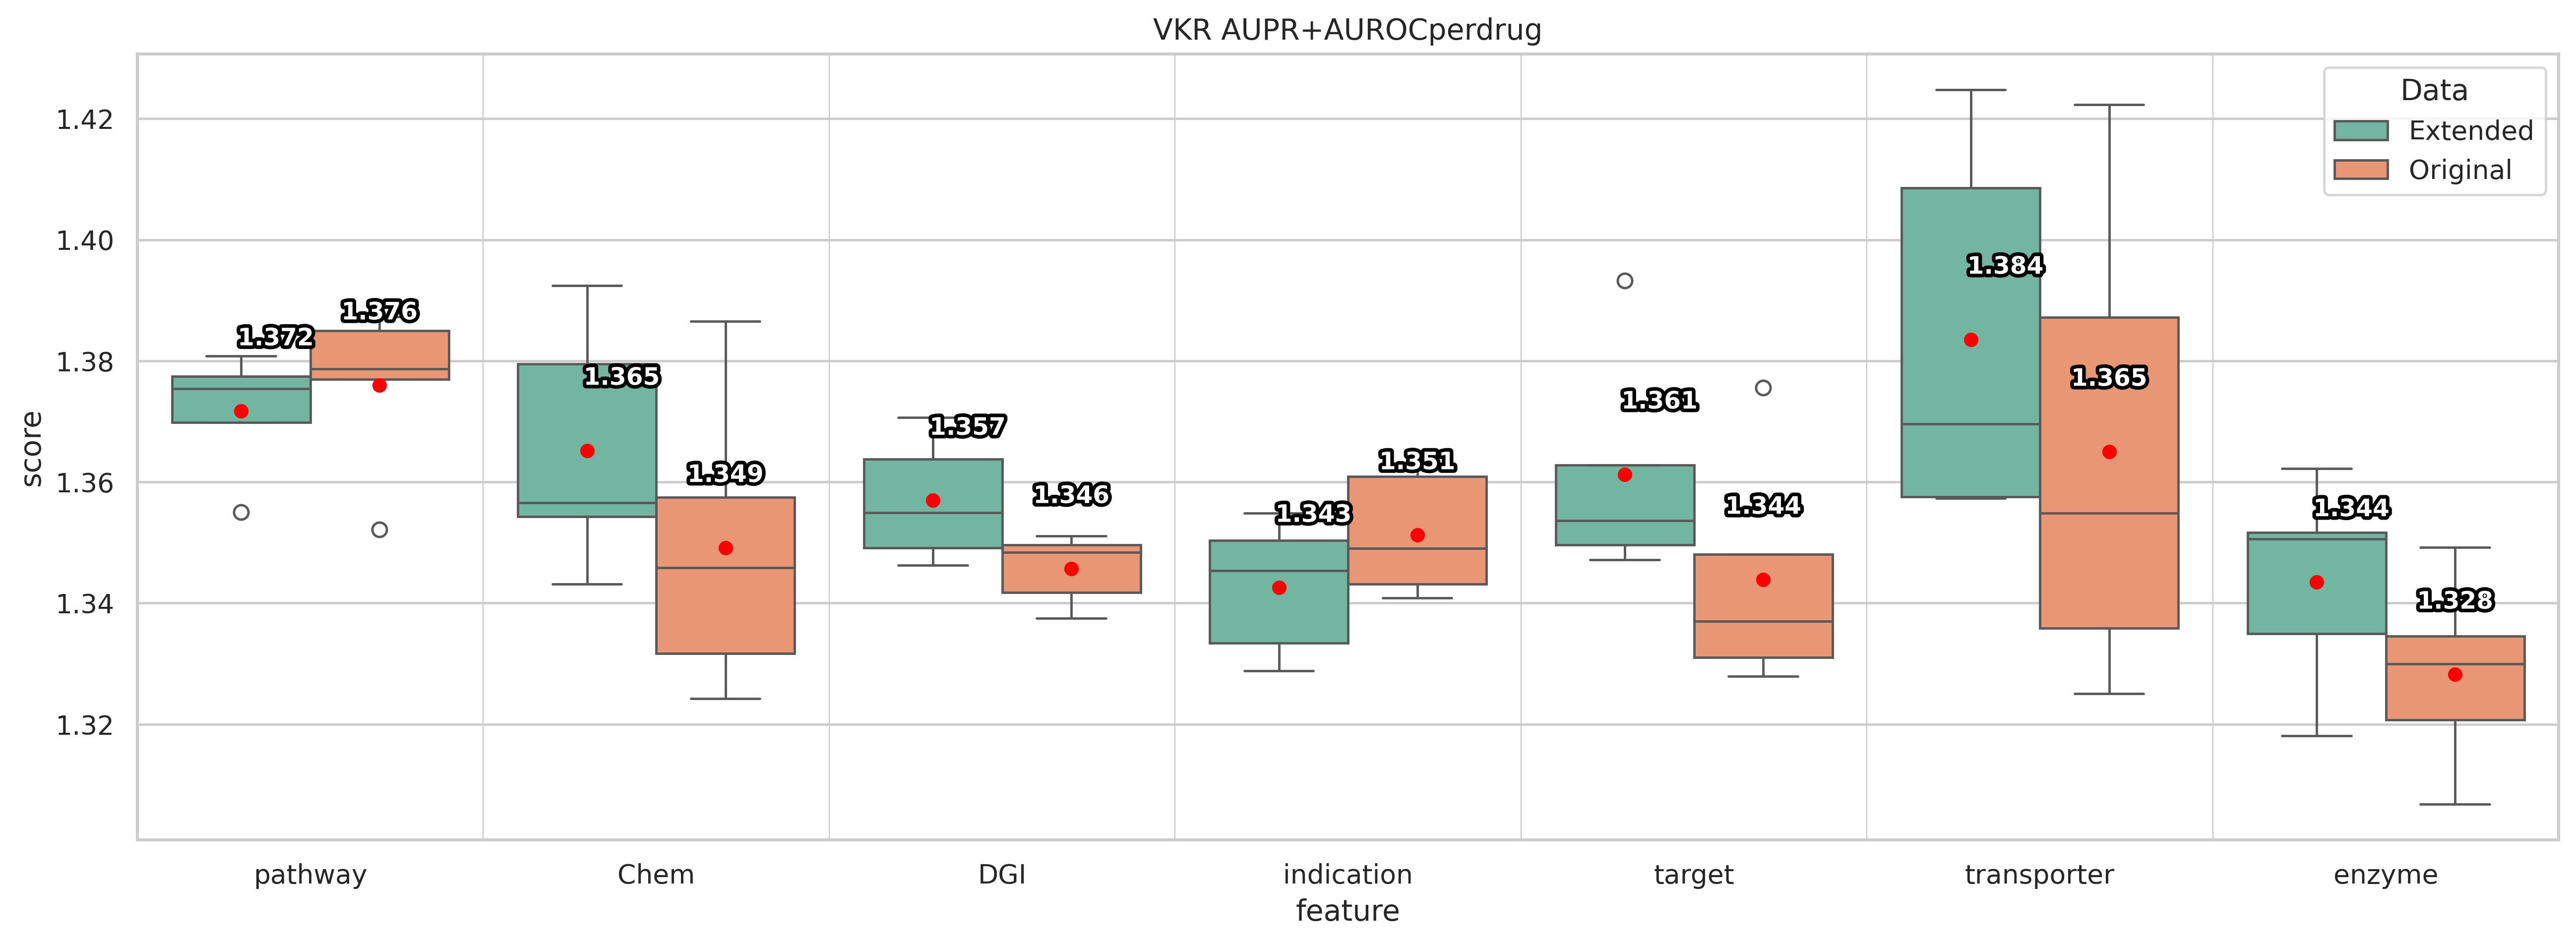

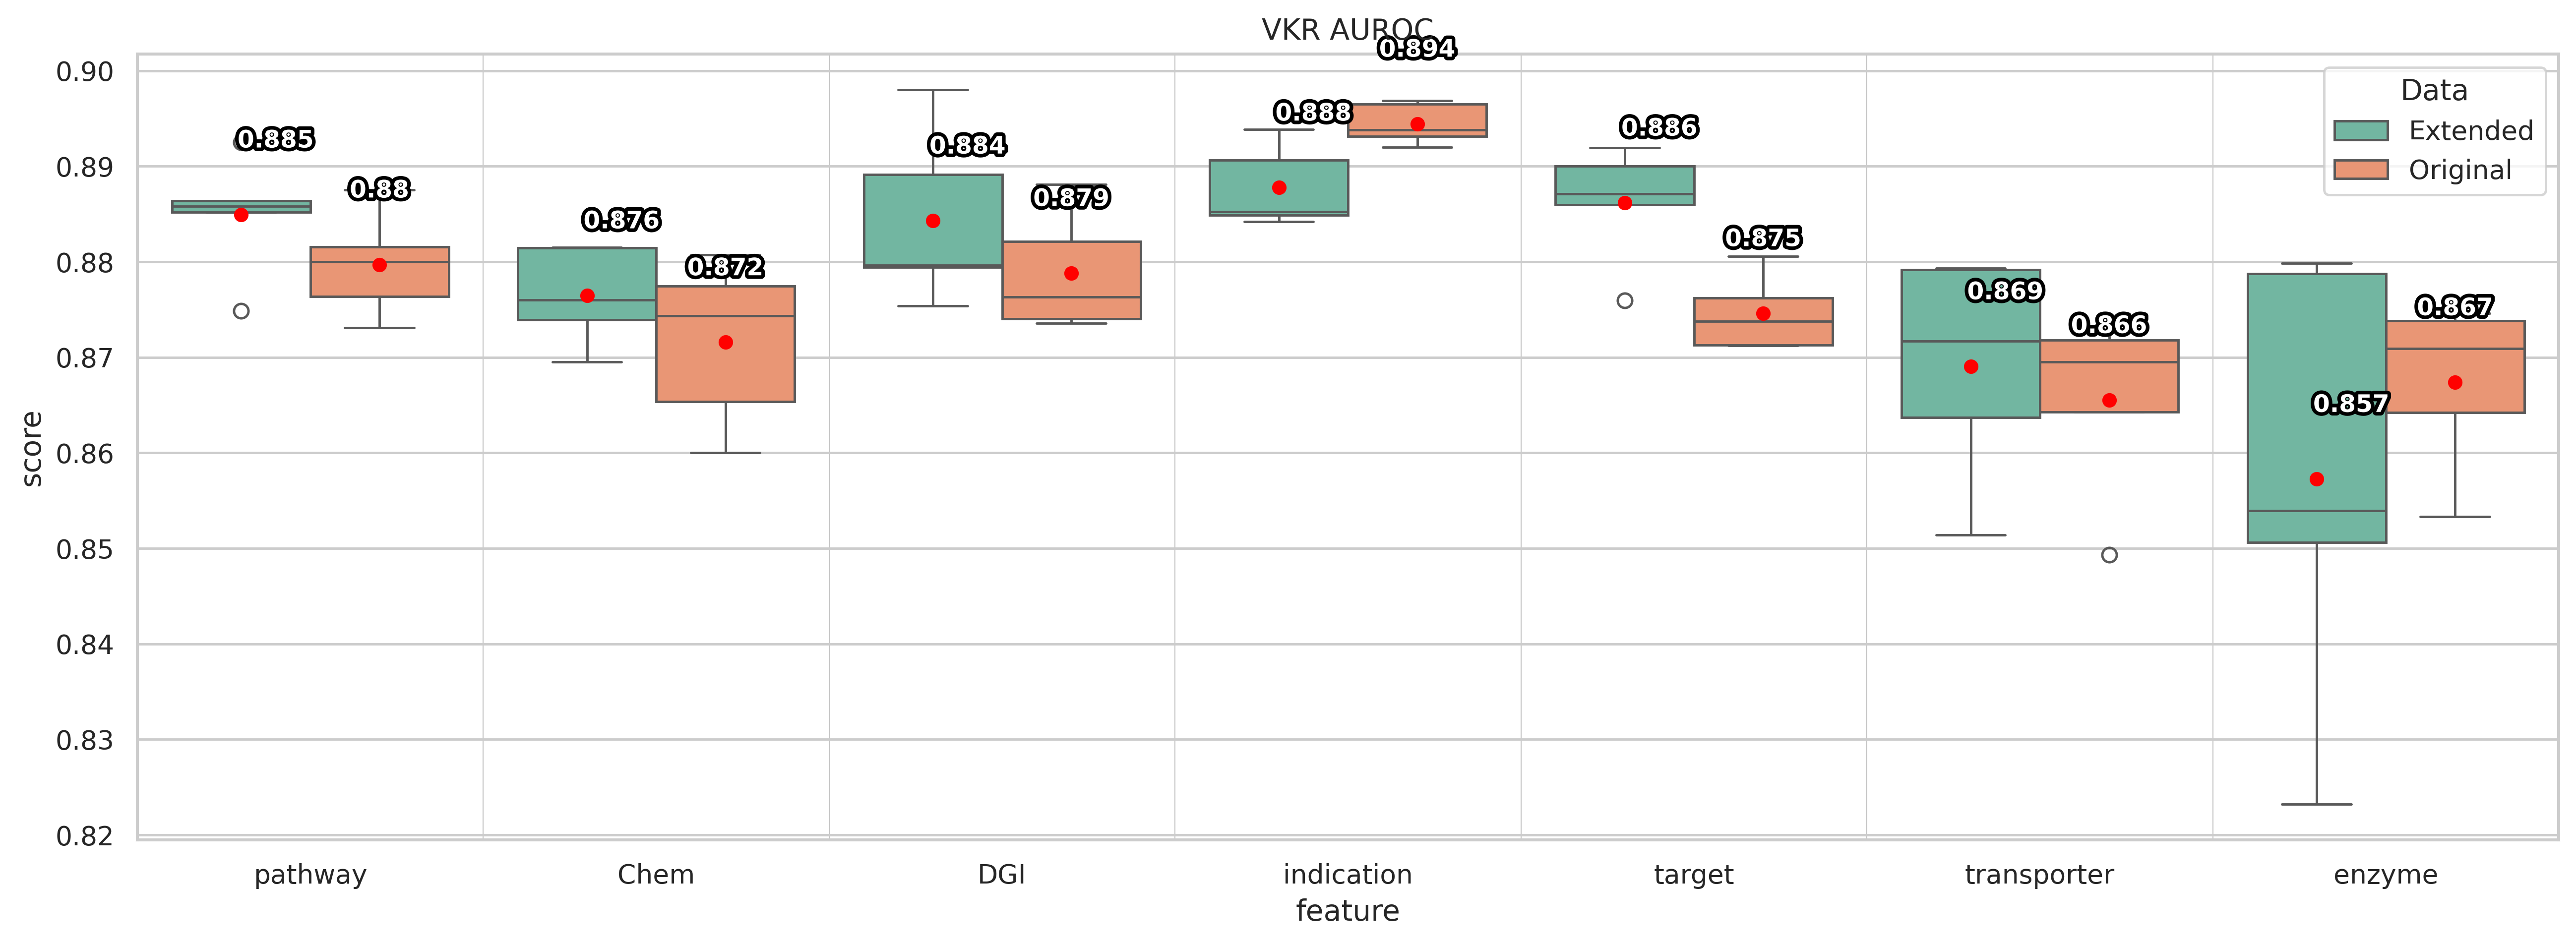

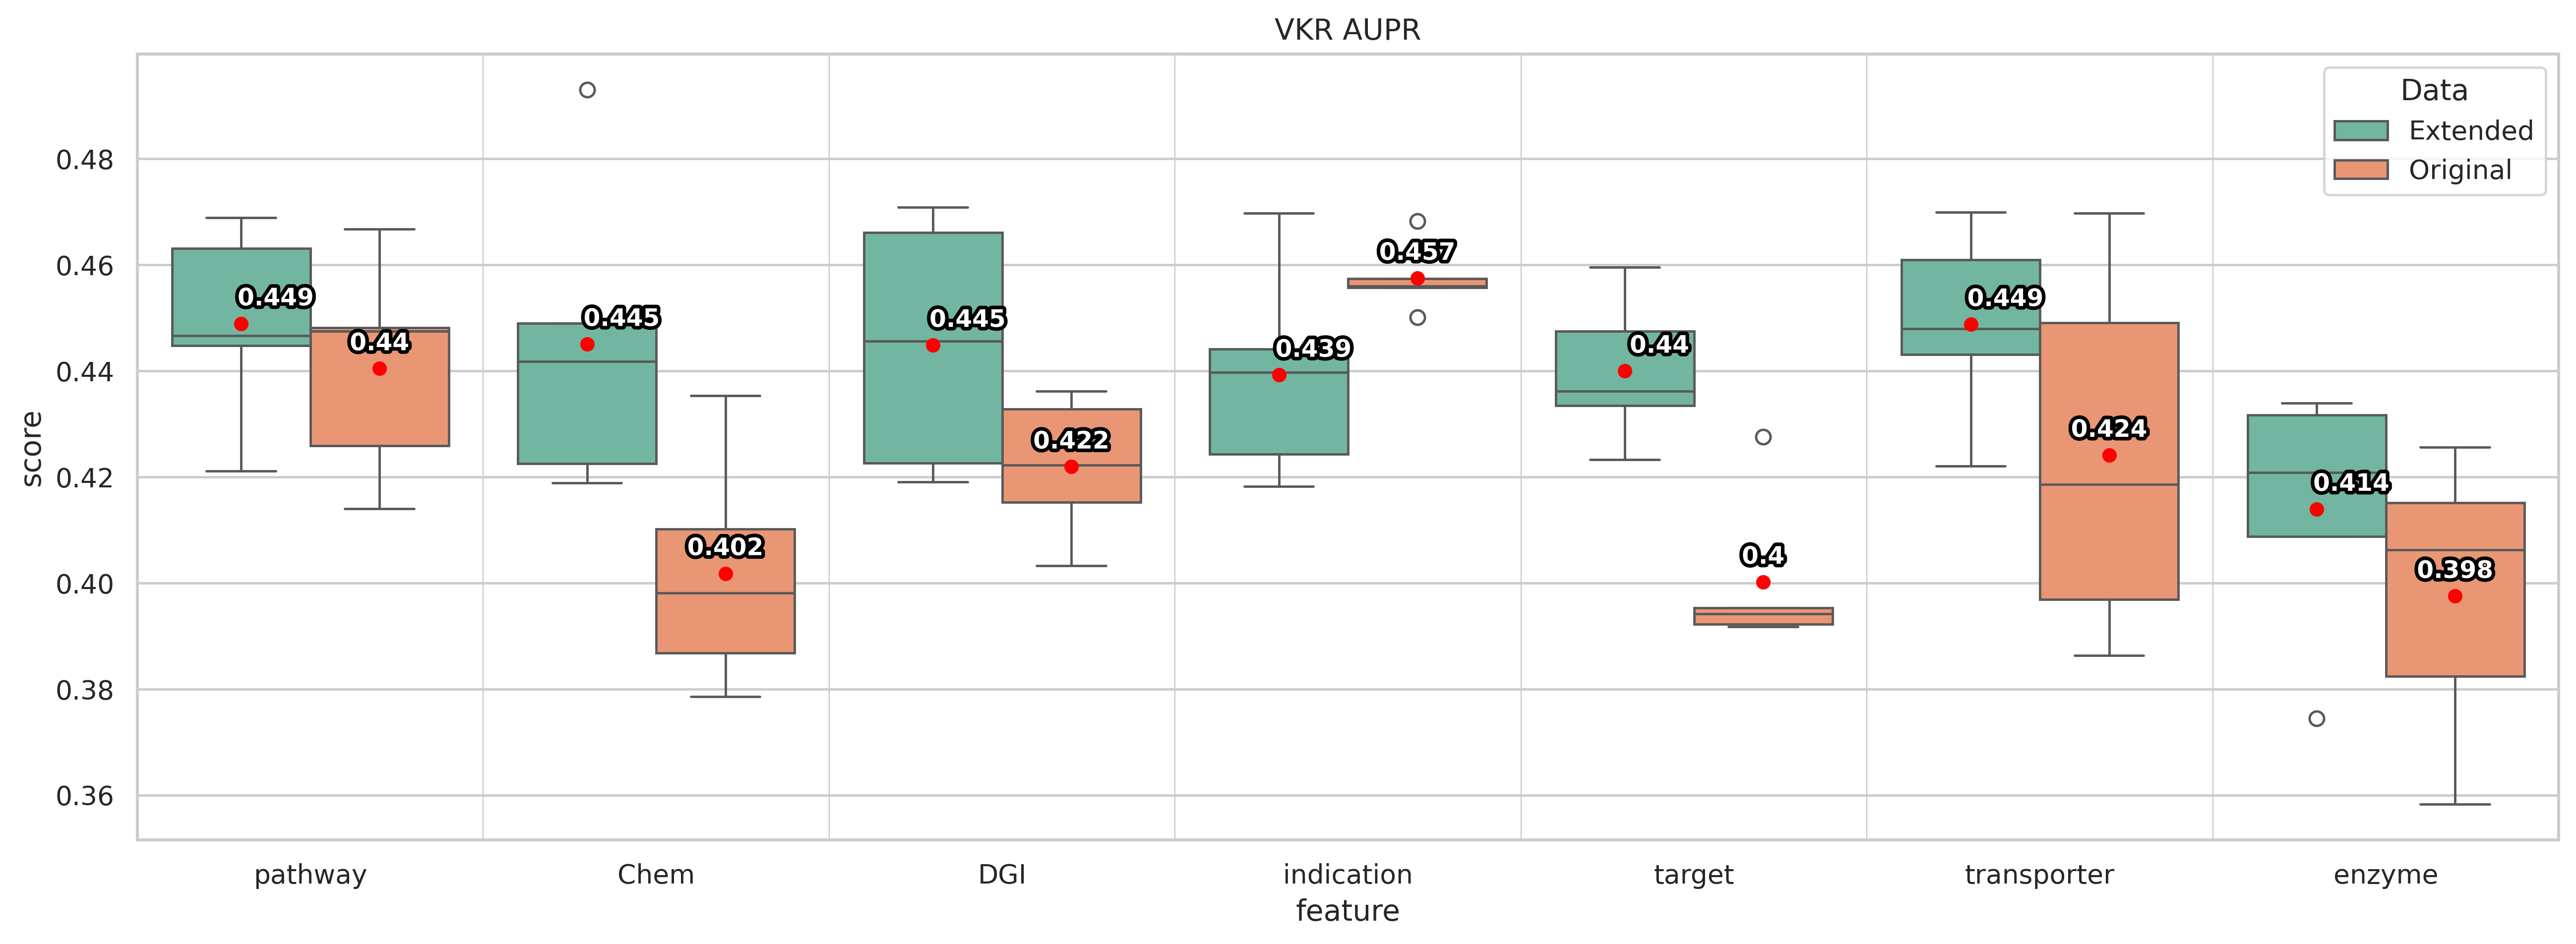

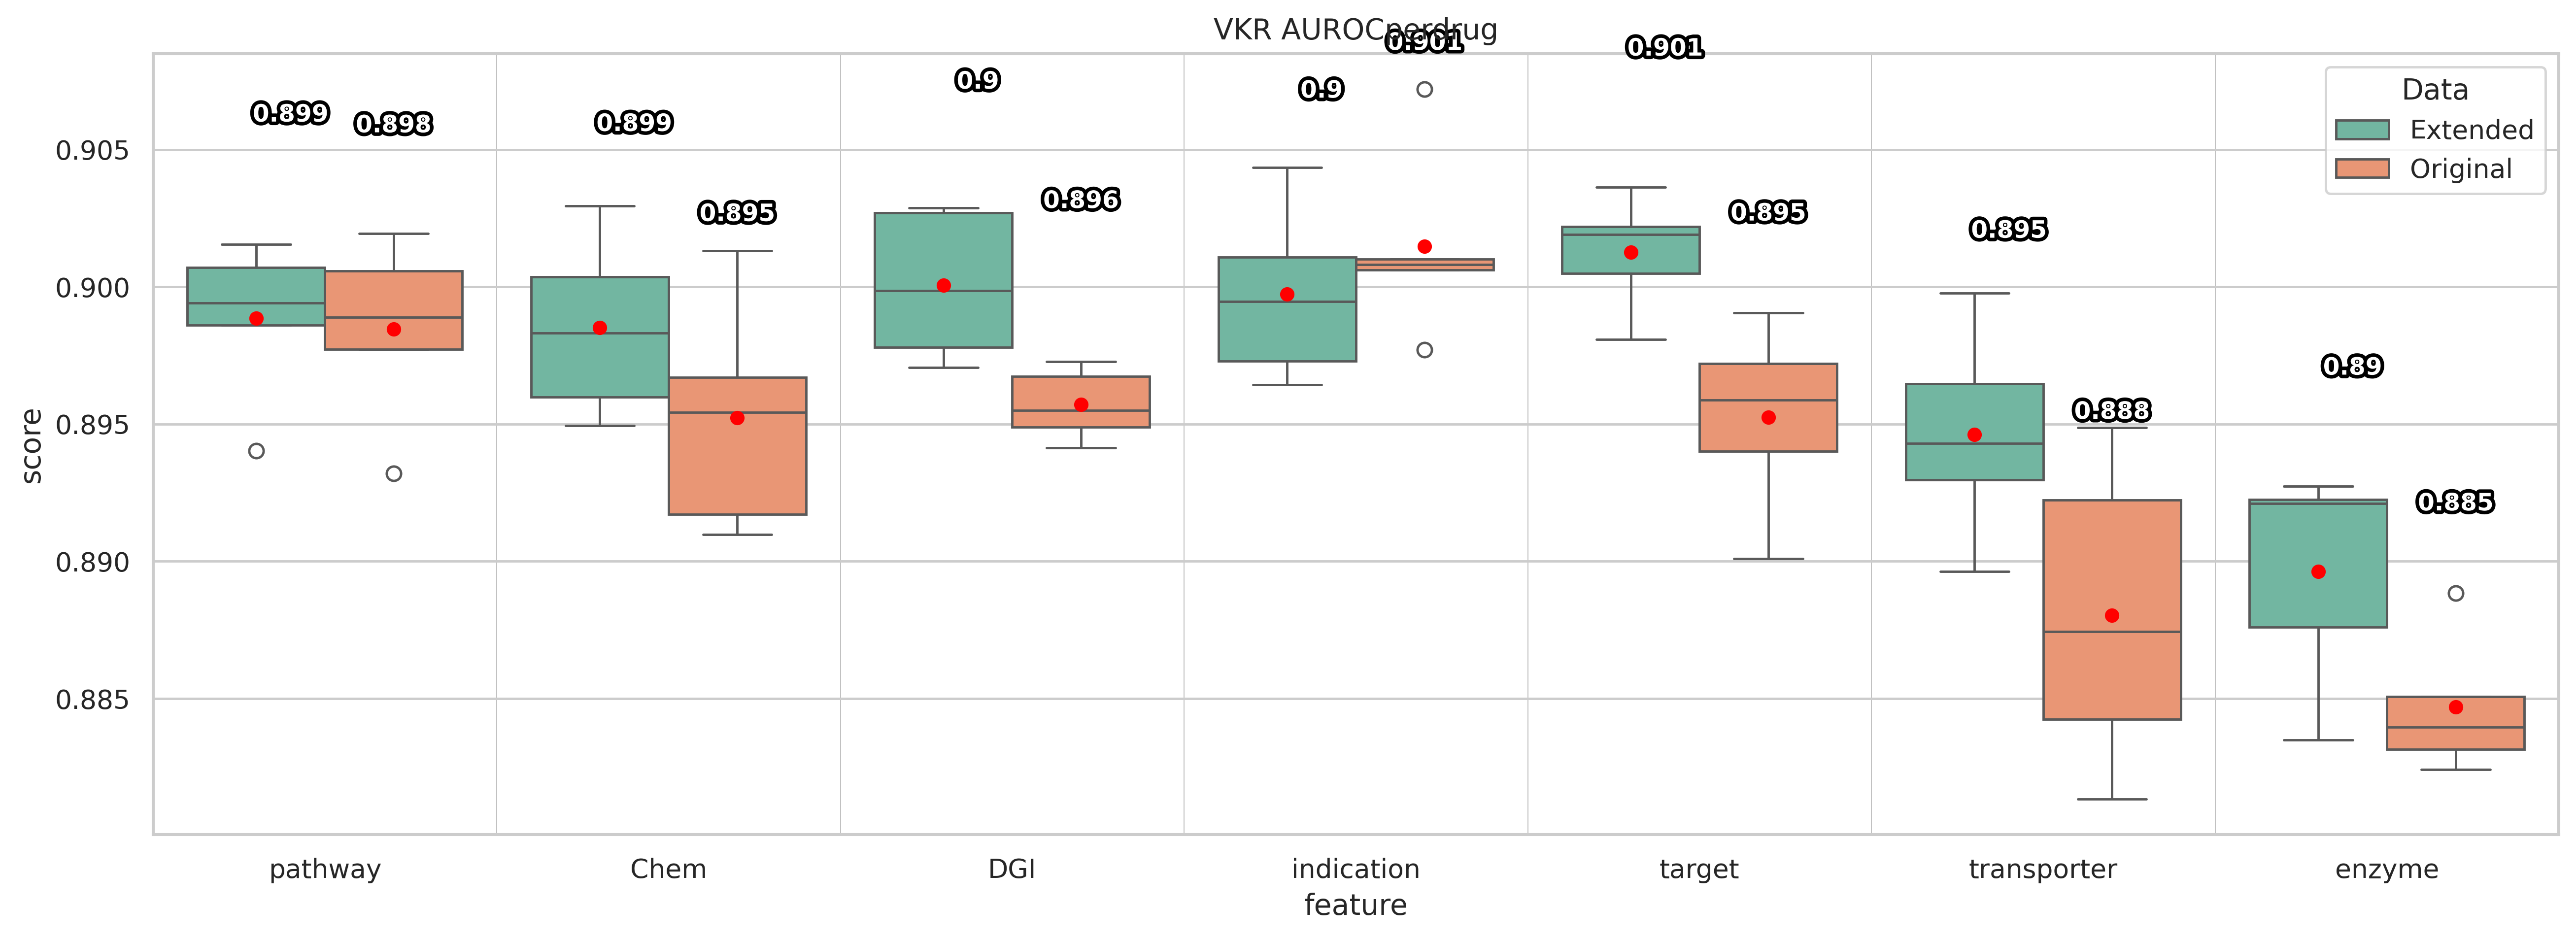

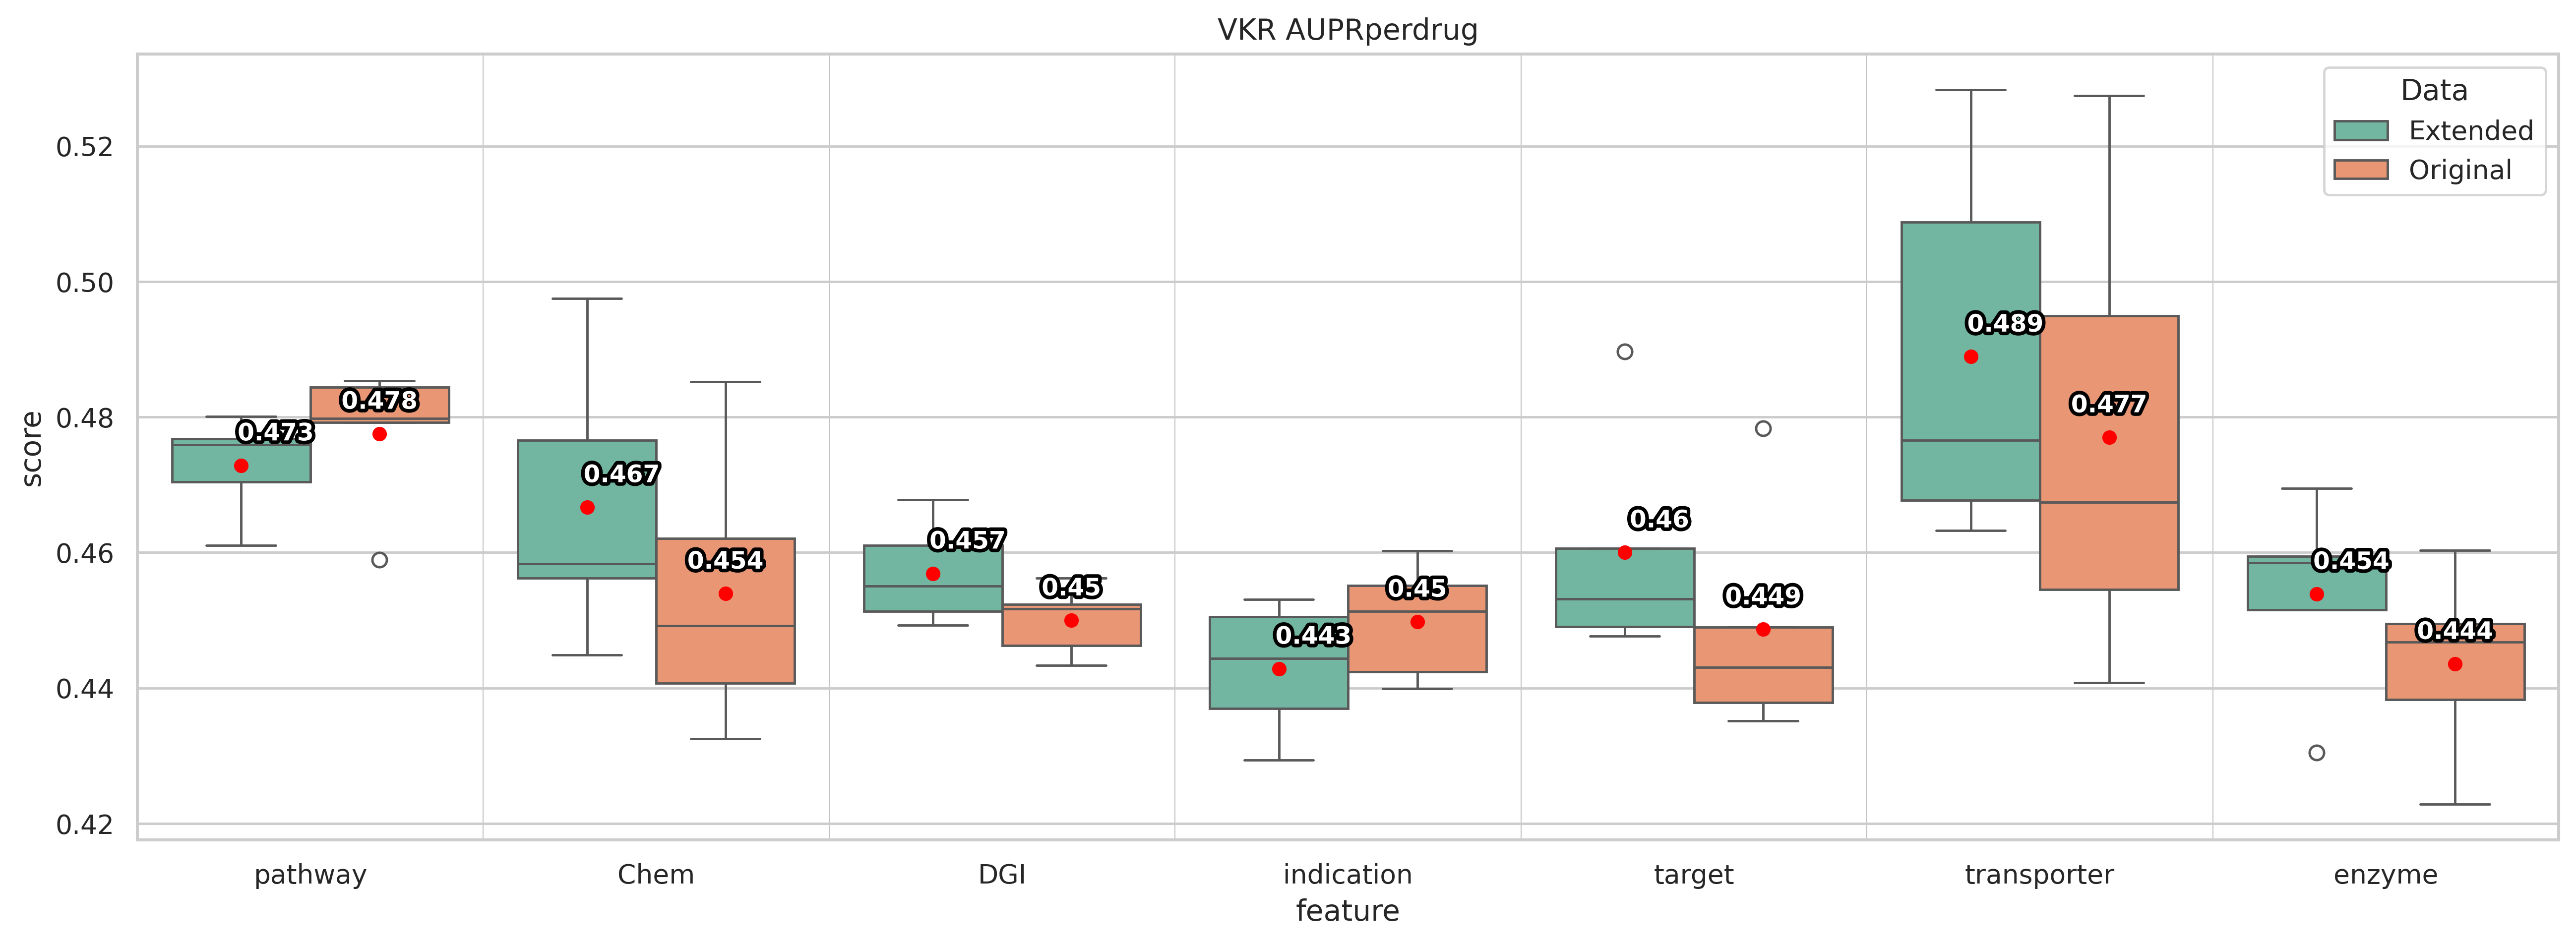

In [108]:
# metrice_names = ["AUROC", "AUPR", "AUPR+AUROC"]
metrice_names = ["AUPR+AUROC", "AUPR+AUROCperdrug", "AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]
methods = ["KR", "SKR", "VKR"]
APPFCs = ["Extended", "Original"]
for method in methods:
    df_sorted_method = df_sorted[df_sorted["method"] == method].copy()
    for metrice in metrice_names:
        # sns.set_style('white')
        plt.figure(figsize=(18, 6), dpi=350)
    
        sns.set_theme(rc={'figure.figsize':(18, 6)},style='whitegrid')
        # sns.axes_style("whitegrid")
        dfplot = df_sorted_method[df_sorted_method["metric"]==metrice]
        means = {}
        vertical_offset = dfplot['score'].mean() * 0.008
        ax = sns.boxplot(x = dfplot['feature'], 
                    y = dfplot['score'], 
                    hue = dfplot['Data'], 
                    palette = 'Set2',
                    showmeans=True,
                    meanprops={'marker':'o',
                               'markerfacecolor':'red', 
                               'markeredgecolor':'red',
                               'markersize':'5'}
                               )
        for APPFC in APPFCs:
            means[APPFC] = dfplot[dfplot["Data"]==APPFC].groupby(['feature'])["score"].mean()
        i = -0.4
    
        for APPFC in APPFCs:
            i += 0.3
            for xtick in ax.get_xticks():
                text = ax.text(xtick + i, means[APPFC][xtick] + vertical_offset, round(means[APPFC][xtick], 3), 
                               horizontalalignment='center',size='small',color='white',weight='semibold')
                text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])
    
        ax.xaxis.set_minor_locator(MultipleLocator(0.5))
        ax.xaxis.grid(True, which='minor', color='black', lw=0.1)
        plt.title(method + " " + metrice)
        plt.savefig(fname=f"figs/{SEs_name}_{method}_{metrice}.jpg", bbox_inches="tight")
        plt.show()

In [98]:
methods = ["SKR", "KRR", "VKR"]
for method in methods:    
    df = pd.DataFrame()
    for m, fs in results["nested_cv"][method].items():
        for f, mes in fs.items():
            for me, scores in mes.items():
                temp_df = pd.DataFrame({
                    'APPFC': m,
                    'feature': f,
                    'metric': me,
                }, index=["1"])
                temp_df2 = pd.concat([temp_df, pd.DataFrame(scores, columns=["1"]).T], axis=1)
                df = pd.concat([df, temp_df2], ignore_index=True)
    for m in metrice_names:
        for f in features_names:
            df2 = df[(df["metric"] == m) & (df["feature"] == f)]
            df3 = df2.iloc[:, np.array([0, 3, 4, 5, 6, 7])]
            df4 = df3.set_index(df3.columns[0])
            df5 = df4.T.ptests(paired=True, stars=False)
            df5.to_excel(f'results/pvalue_{SEs_name}_{method}_{f}_{m}.xlsx')